# TODO
- napsat 5 nejzajímavějších kryptoměn a zmínit používaný zbytek
- projít všechna data, vypsat základní statistiky (obecný) ke všem a vyselektovat cca 5 nejlepších a u nich se zaměřit na detaily (závislost v čase, na prodaném objemu, na počtu obchodů)
- průměrná doba výskytu trojúhelníku
- napsat k trojúhelníkům denní statistiky výskytu, nejlepších, nejhorších 
- možnost zaměřit se na neefektivitu trhu, zmínit že není regulovaný a proto na něm vznikají arbitráže
- zmínit problémy vytěžitelnosti a jak by to reálně pobíhalo
- průměrný objem nasbíraných dat
- v praktické části popsat strukturu ukládaných dat (csv, json)
- v praktické části se zaměřit na používané algoritmy (jak sbírám order book, do jaké hloubky, jak ho procházím a znovu ukládám) 

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, isdir
from typing import Dict, Tuple, Sequence
import threading

In [2]:
rate = {
    "BTC": 6837.51,
    "LTC": 41,
    "ETH": 156.7,
    "XRP": 0.185965,
    "USDT": 1,
    "BCH": 222.98,
    "BNB": 15.53,
    "EOS": 2.44,
    "XMR": 53.37,
    "TRX": 0.012597
}

In [3]:
def fetch_directories(path: str) -> [str]:    
    directories = []
    try:
        directories = [join(path, f) for f in listdir(path) if isdir(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return directories
    return directories

def fetch_files(path: str) -> [str]:    
    files = []
    try:
        files = [f for f in listdir(path) if isfile(join(path, f))] 
    except:
        print("Trouble opening a directory")
        return files
    return files

In [22]:
class FileHandler:
    def __init__(self, file: str, path: str):
        self.filename = file
        self.total_gain = 0
        self.average_gain = 0
        self.max_gain = 0
        self.best_gains = None
        self.date = file[-15:-5:]
        with open(join(path, file)) as f:
            tmp = json.loads(f.read())
            self.content = tmp["arbitrage_stats"]
            self.arbitrages_count = tmp["arbitrages_count"]
            self.without_fees_count = tmp["without_fees_count"]
            self.all_count = tmp["all_count"]
        self.scores = [x["score"] for x in self.content]
    
    @property
    def filename(self) -> str:
        return self.__filename
    
    @filename.setter
    def filename(self, filename: str):
        self.__filename = filename
        
    @property
    def content(self) -> str:
        return self.__content
    
    @content.setter
    def content(self, content: str):
        self.__content = content
        
    @property
    def total_gain(self) -> float:
        return self.__total_gain
    
    @total_gain.setter
    def total_gain(self, total_gain: float):
        self.__total_gain = total_gain
        
    @property
    def max_gain(self) -> float:
        return self.__max_gain
    
    @max_gain.setter
    def max_gain(self, max_gain: float):
        self.__max_gain = max_gain
        
    @property
    def average_gain(self) -> float:
        return self.__average_gain
    
    @average_gain.setter
    def average_gain(self, average_gain: float):
        self.__average_gain = average_gain
        
    @property
    def scores(self) -> [float]:
        return self.__scores
    
    @scores.setter
    def scores(self, scores: [float]):
        self.__scores = scores
        
    @property
    def arbitrages_count(self) -> int:
        return self.__arbitrages_count
    
    @arbitrages_count.setter
    def arbitrages_count(self, arbitrages_count: int):
        self.__arbitrages_count = arbitrages_count     
        
    @property
    def without_fees_count(self) -> int:
        return self.__without_fees_count
    
    @without_fees_count.setter
    def without_fees_count(self, without_fees_count: int):
        self.__without_fees_count = without_fees_count  
        
    @property
    def all_count(self) -> int:
        return self.__all_count
    
    @all_count.setter
    def all_count(self, all_count: int):
        self.__all_count = all_count  
        
    @property
    def date(self) -> str:
        return self.__date
    
    @date.setter
    def date(self, date: str):
        self.__date = date  
        
    def get_best_indexes_count(self) -> Dict[int, int]:
        indexes = np.array([x['supply_gain_index'] for x in self.content]).ravel()
        tmp = np.array([x['demand_gain_index'] for x in self.content]).ravel()
        indexes = np.array((indexes, tmp)).ravel()
        unique, counts = np.unique(indexes, return_counts = True)
        return dict(zip(unique, counts))
    
    def get_number_of_arbitrages(self) -> int:
        return len(self.scores)
    
    def get_average_score(self) -> float:
        if len(self.scores):
            return sum(self.scores)/len(self.scores)
        return 1
    
    def get_best_score(self) -> float:
        if len(self.scores):
            return max(self.scores)
        return 1
    
    def get_best_gains(self):
        best_gains = np.array([x["supply_gain"] for x in self.content])
        best_gains = np.array((best_gains, [x["supply_gain"] for x in self.content])).ravel()
        best_gains = best_gains[self.best_gains != 0.0]
        self.total_gain = np.sum(best_gains)
        self.average_gain = np.average(best_gains)
        if len(best_gains[0]):
            self.max_gain = np.max(best_gains)
        else:
            self.max_gain = 0
        return best_gains

    def get_first_currency(self) -> str:
        if (self.content):
            return self.content[0]['pairs'][0]['currency'][0:3]
        return ""


In [23]:
class Triangle:
    def __init__(self, files: [str], path: str, triangle_name: str):
        self.__files = []
        self.__index_counts = None
        self.__path = path
        self.__best_gains = None
        self.__name = triangle_name
        for f in files:
            self.__files.append(FileHandler(f, path))
            

    @property
    def path(self) -> str:
        return self.__path
    
    @property
    def name(self) -> str:
        return self.__name
            
    def get_best_indexes_count(self) -> Dict[int, int]:
        if self.__index_counts is None:
            index_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
            for d in np.array([x.get_best_indexes_count() for x in self.__files]):
                for k in d.keys():
                    index_counts[k] += d[k]
            self.__index_counts = index_counts
        return self.__index_counts
    
    def get_daily_number_average_of_arbitrages(self) -> int:
        return sum([x.get_number_of_arbitrages() for x in self.__files])/len(self.__files)
    
    def get_average_score(self) -> float:
        return sum([x.get_average_score() for x in self.__files])/len(self.__files)
    
    def get_best_score(self) -> float:
        return max([x.get_best_score() for x in self.__files])
    
    def get_best_gains(self):
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return self.__best_gains
    
    def get_overall_best_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.max_gain for x in self.__files])
    
    def get_average_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.average([x.total_gain for x in self.__files])
    
    def get_total_gain(self) -> float:
        if self.__best_gains is None:
            self.__best_gains = [x.get_best_gains() for x in self.__files]
        return np.max([x.total_gain for x in self.__files])
    
    def get_first_currency(self) -> str:
        for f in self.__files:
            tmp = f.get_first_currency()
            if tmp != "":
                return tmp
        return ""
    
    def get_data_length(self) -> int:
        return len(self.__files)
    
    def get_arbitrages_counts(self) -> ([int], [str]):
        return [x.arbitrages_count for x in self.__files], [x.date for x in self.__files]


In [65]:
df = pd.DataFrame(columns=["Days", "Average count", "Average score", "The best score", "The best gain", 
                           "Total inefficiency", "Average daily inefficiency", "Average daily inefficiency (USD)"])
df

Empty DataFrame
Columns: [Days, Average count, Average score, The best score, The best gain, Total inefficiency, Average daily inefficiency, Average daily inefficiency (USD)]
Index: []

In [6]:
def basic_stats(t):
    a = t.get_best_indexes_count()
    tmp = {
        "Name": t.name,
        "Days": t.get_data_length(), 
        "Average count": t.get_daily_number_average_of_arbitrages(),
        "Average score": t.get_average_score(),
        "The best score": t.get_best_score(),
        "The best gain": '{:e} {}'.format(t.get_overall_best_gain(), t.get_first_currency()),
        "Total inefficiency": '{:e} {}'.format(t.get_total_gain(), t.get_first_currency()), 
        "Average daily inefficiency": '{:e} {}'.format(t.get_average_gain(), t.get_first_currency()),
        "Average daily inefficiency (USD)": t.get_average_gain() * rate[t.get_first_currency()]
    }
    return tmp

In [131]:
path = "./output_data/"    

stats = []
count = 0
stop = 99
for directory in fetch_directories(path):
    print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    stats.append(basic_stats(triangle))
    triangle = None
    if count == stop:
        break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [109]:
pd.options.display.float_format = "{:e}".format
pd.DataFrame(stats)

Name  Days  Average count  Average score  The best score  \
0    BTCBCHBNB    22   1.559864e+03   1.002160e+00    1.039020e+00   
1    BTCBNBTRX    22   9.668182e+01   1.000510e+00    1.007800e+00   
2    BTCBNBXMR    22   4.153182e+02   1.001756e+00    1.006420e+00   
3    BTCEOSBNB    22   4.530455e+02   1.000873e+00    1.025380e+00   
4    BTCETHBNB    22   9.135000e+02   1.000474e+00    1.006210e+00   
5    BTCETHEOS    22   3.088227e+03   1.000741e+00    1.012260e+00   
6    BTCETHTRX    40   6.750000e+00   1.000445e+00    1.019190e+00   
7    BTCETHXMR    40   5.815000e+01   1.001318e+00    1.017280e+00   
8    BTCETHXRP    40   3.655000e+01   1.000725e+00    1.022920e+00   
9    BTCLTCBNB    22   5.485909e+02   1.000827e+00    1.007070e+00   
10   BTCLTCETH    40   3.730000e+01   1.000680e+00    1.022520e+00   
11   BTCXRPBNB    22   5.345909e+02   1.000677e+00    1.006400e+00   
12   BTCXRPTRX    40   8.102500e+01   1.001136e+00    1.023790e+00   
13   ETHBNBTRX    22   1.737364e+03   1.000288e+00    1.014520e+00   
14   ETHBNBXMR    40   2.942500e+01   1.000662e+00    1.045810e+00   
15   ETHEOSBNB    22   1.859182e+03   1.000801e+00    1.020280e+00   
16   ETHXRPBNB    40   9.625000e+00   1.000428e+00    1.033420e+00   
17   ETHXRPTRX    40   1.467500e+01   1.000453e+00    1.014140e+00   
18   LTCETHBNB    40   1.172500e+01   1.000602e+00    1.026660e+00   
19  USDTBCHBNB    40   5.860000e+01   1.002924e+00    1.114940e+00   
20  USDTBNBTRX    22   1.905727e+03   1.002041e+00    1.014850e+00   
21  USDTBNBXMR    40   1.310000e+02   1.003017e+00    1.142000e+00   
22  USDTBTCBCH    22   7.781250e+04   1.005825e+00    1.049500e+00   
23  USDTBTCBNB    22   1.386727e+04   1.003890e+00    1.036980e+00   
24  USDTBTCEOS    41   7.353244e+03   1.004355e+00    1.101560e+00   
25  USDTBTCETH    22   5.491591e+03   1.002779e+00    1.031450e+00   
26  USDTBTCLTC    40   8.122675e+03   1.004167e+00    1.060710e+00   
27  USDTBTCTRX    40   7.308100e+03   1.002958e+00    1.085550e+00   
28  USDTBTCXMR    40   5.706875e+03   1.004054e+00    1.063980e+00   
29  USDTBTCXRP    40   5.384425e+03   1.003819e+00    1.060900e+00   
30  USDTEOSBNB    40   8.835000e+01   1.002727e+00    1.104790e+00   
31  USDTETHBNB    22   2.466909e+03   1.001776e+00    1.030900e+00   
32  USDTETHEOS    22   1.176136e+03   1.001257e+00    1.022300e+00   
33  USDTETHTRX    22   2.154591e+03   1.001069e+00    1.029200e+00   
34  USDTETHXMR    22   1.770545e+03   1.001585e+00    1.028470e+00   
35  USDTETHXRP    22   2.323455e+03   1.000923e+00    1.028720e+00   
36  USDTLTCBNB    40   7.170000e+01   1.002772e+00    1.104170e+00   
37  USDTLTCETH    22   2.288182e+03   1.001453e+00    1.030510e+00   
38  USDTXRPBNB    40   4.010000e+01   1.002853e+00    1.111370e+00   
39  USDTXRPTRX    40   1.120750e+02   1.002184e+00    1.074050e+00   
40   XRPBNBTRX    22   8.239545e+02   1.000584e+00    1.013270e+00   

       The best gain Total inefficiency Average daily inefficiency  \
0   1.528940e-03 BCH   2.748139e+01 BCH           1.249289e+00 BCH   
1   1.823210e-14 TRX   3.646420e-14 TRX           1.657464e-15 TRX   
2   4.975940e-06 XMR   4.669594e-03 XMR           2.147775e-04 XMR   
3   6.440760e-07 EOS   5.593003e-04 EOS           2.613382e-05 EOS   
4   4.179320e-07 BNB   1.560732e-03 BNB           7.094248e-05 BNB   
5   8.940850e-08 EOS   1.656258e-03 EOS           7.529230e-05 EOS   
6   7.042350e-12 TRX   8.167343e-11 TRX           3.721943e-12 TRX   
7   2.275100e-06 XMR   6.313177e-05 XMR           2.228290e-06 XMR   
8   4.160390e-10 XRP   4.707160e-07 XRP           1.182209e-08 XRP   
9   1.995000e-05 LTC   2.666775e-02 LTC           1.221867e-03 LTC   
10  2.306770e-05 LTC   3.733013e-04 LTC           9.984272e-06 LTC   
11  5.459300e-09 XRP   9.123745e-06 XRP           4.147660e-07 XRP   
12  9.040310e-09 TRX   3.757080e-07 TRX           1.590293e-08 TRX   
13  0.000000e+00 TRX   0.000000e+00 TRX           0.000000e+00 TRX   
14  8.770460e-04 XM

In [32]:
import os

D:\School\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


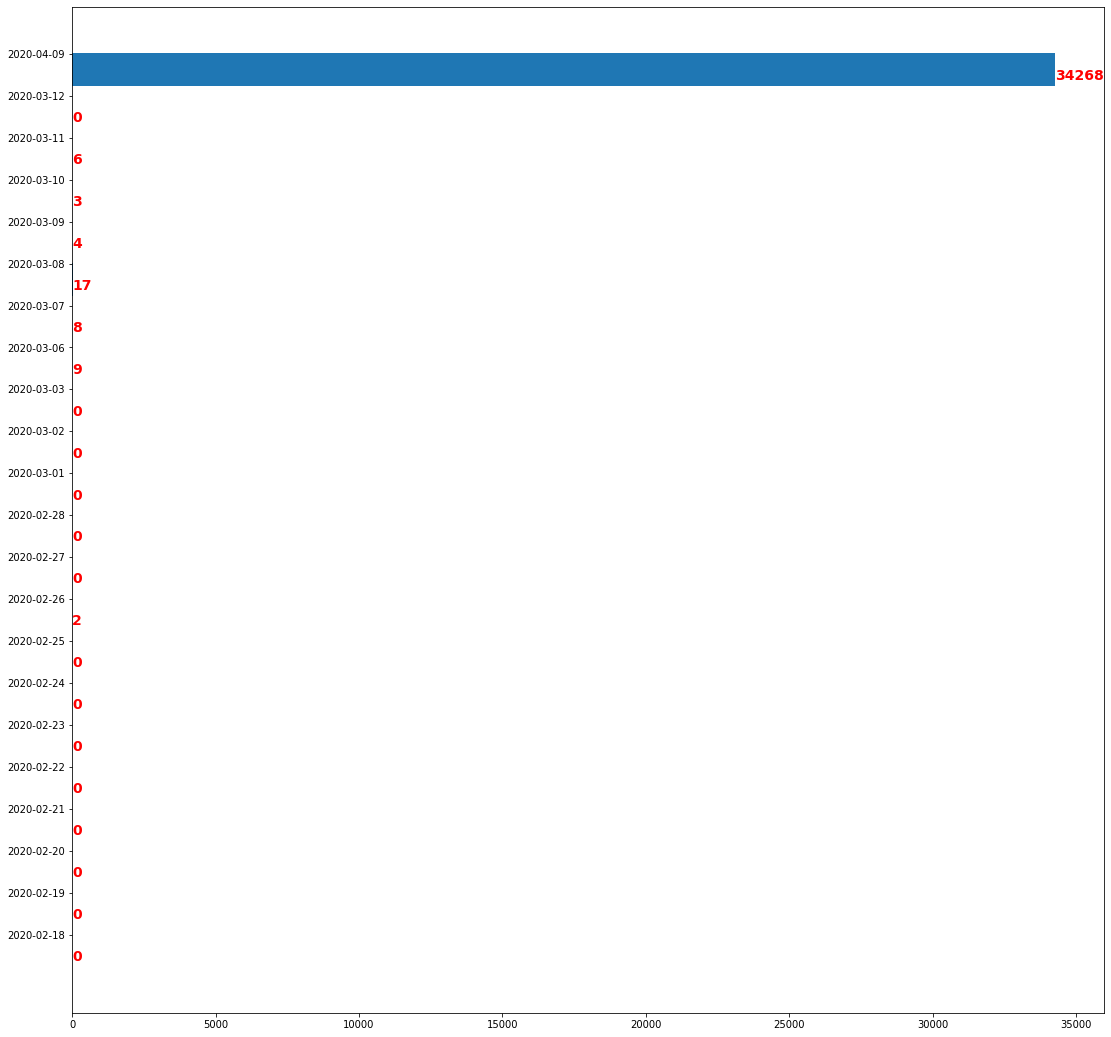

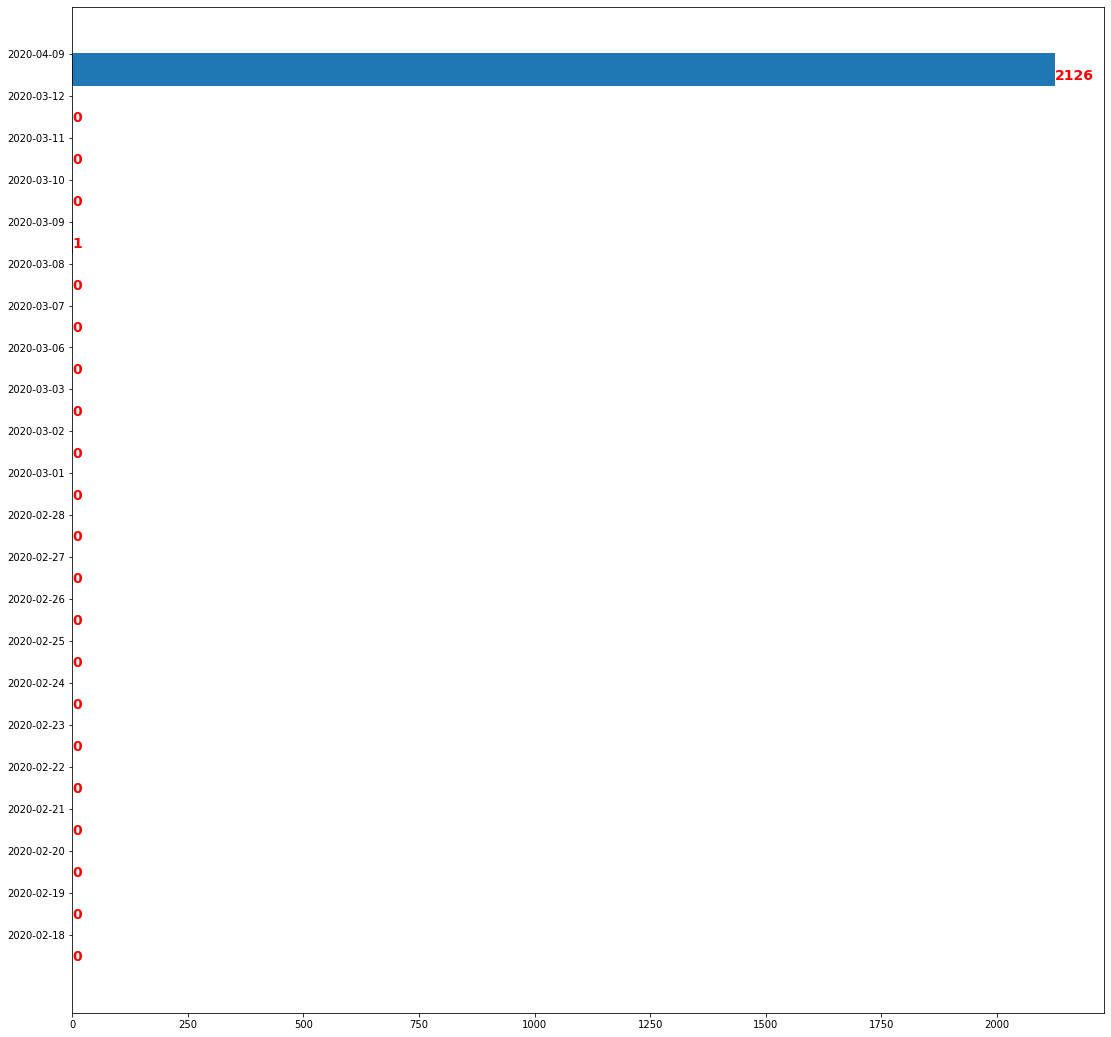

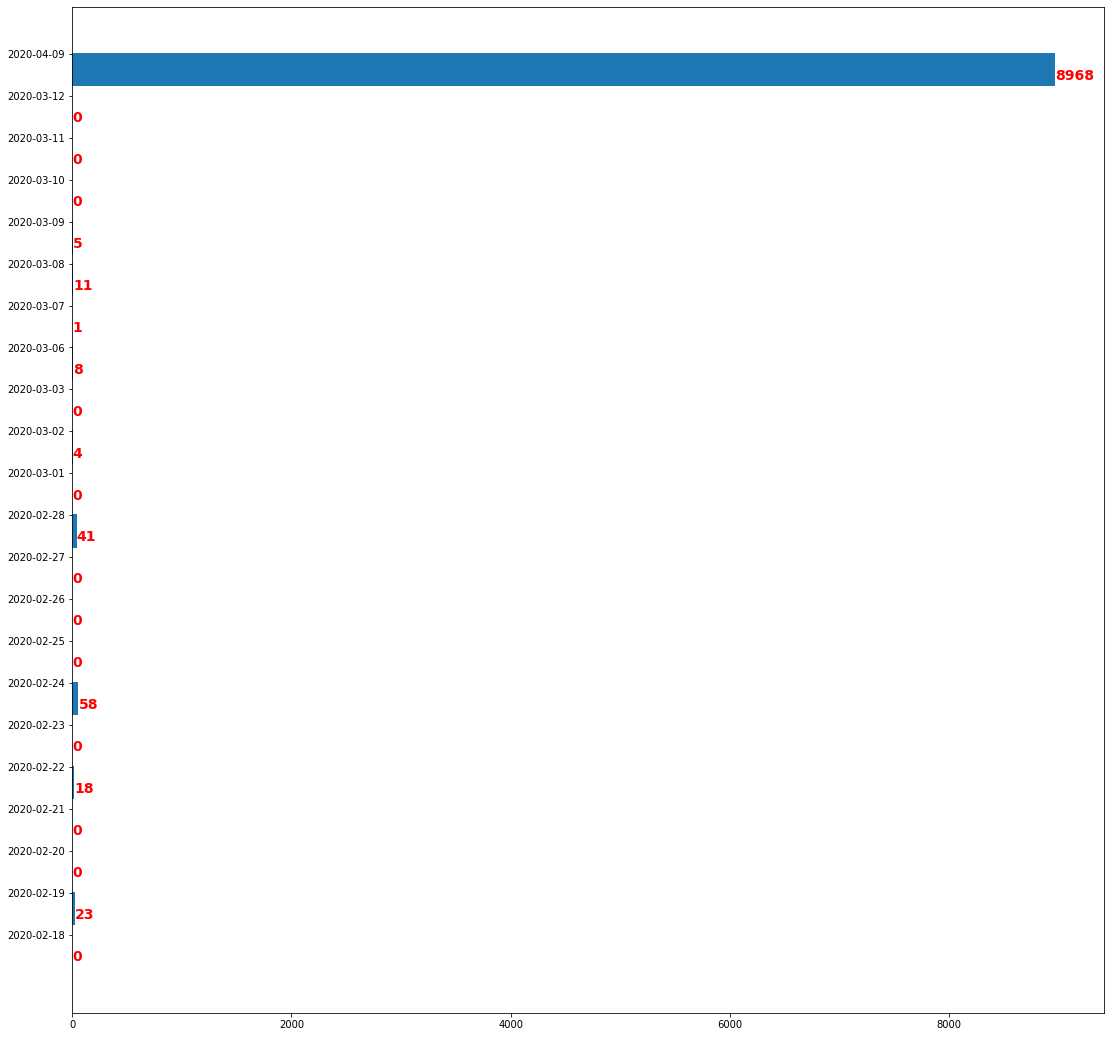

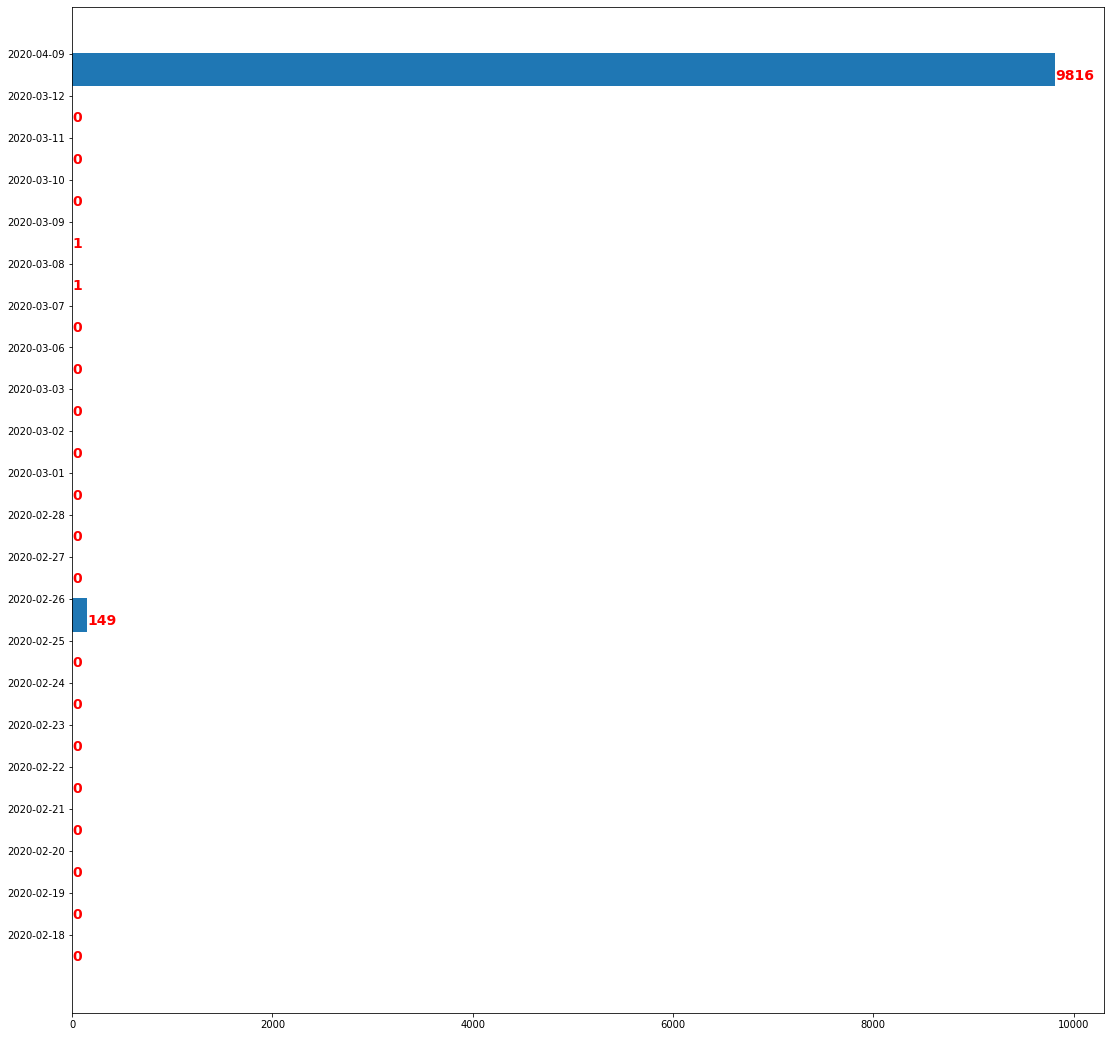

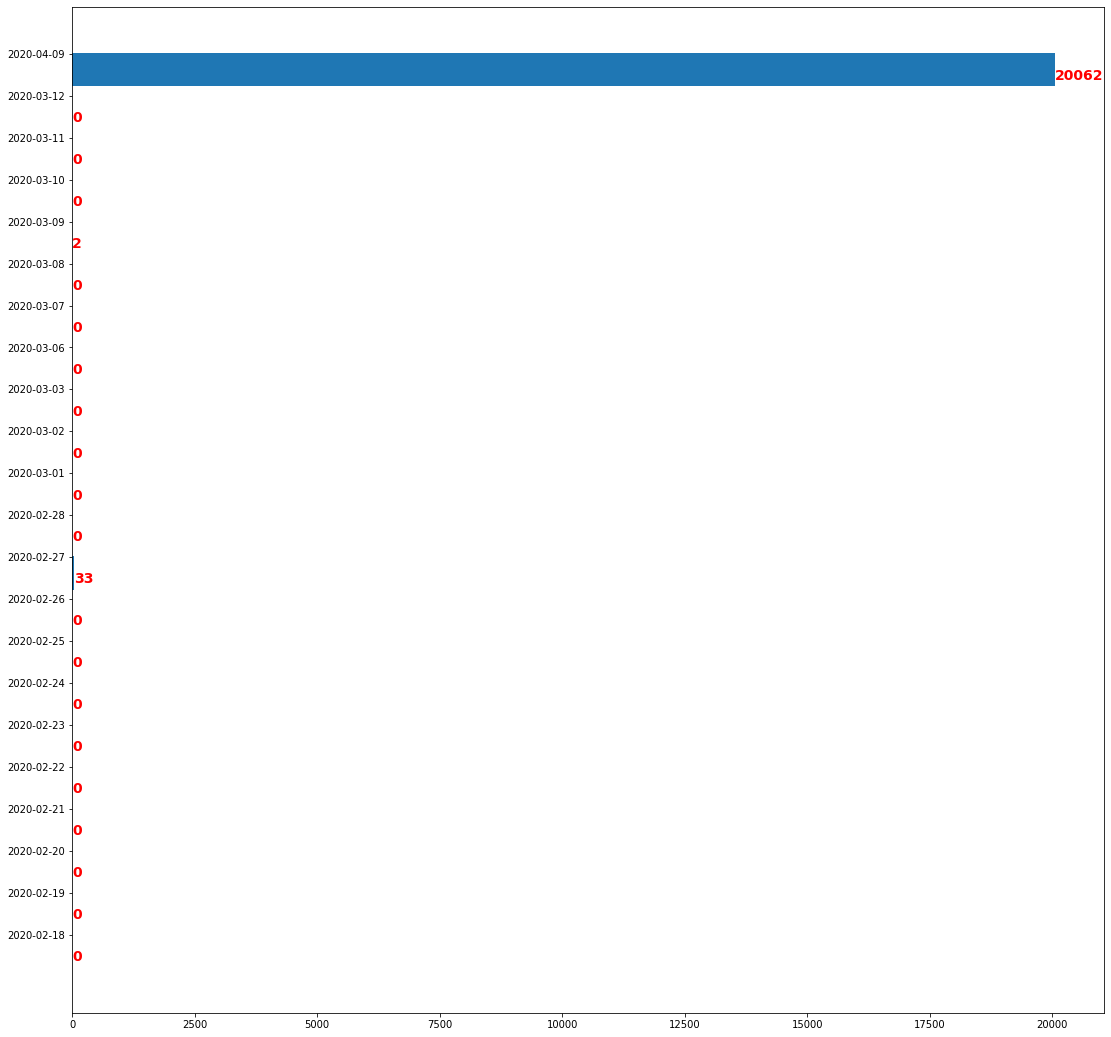

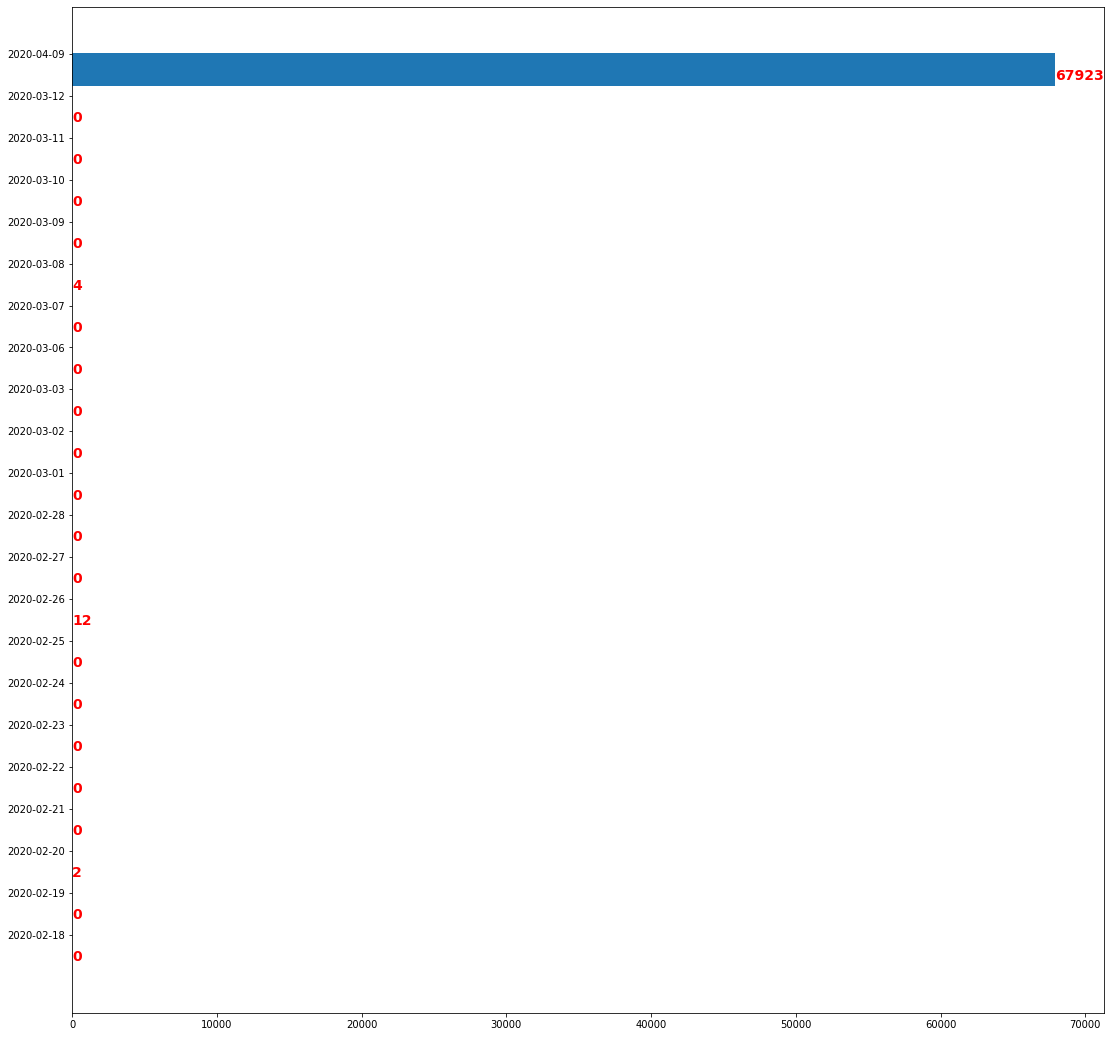

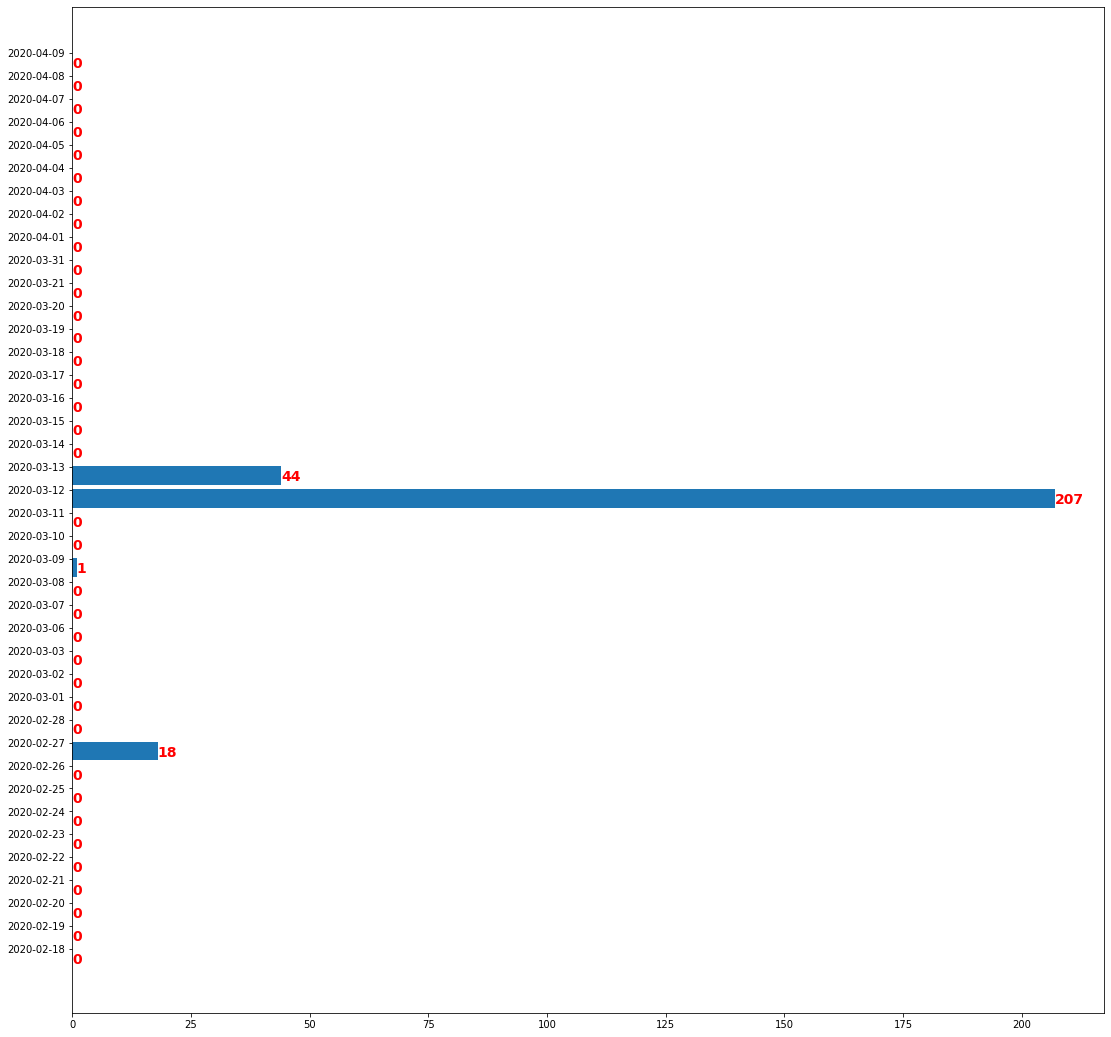

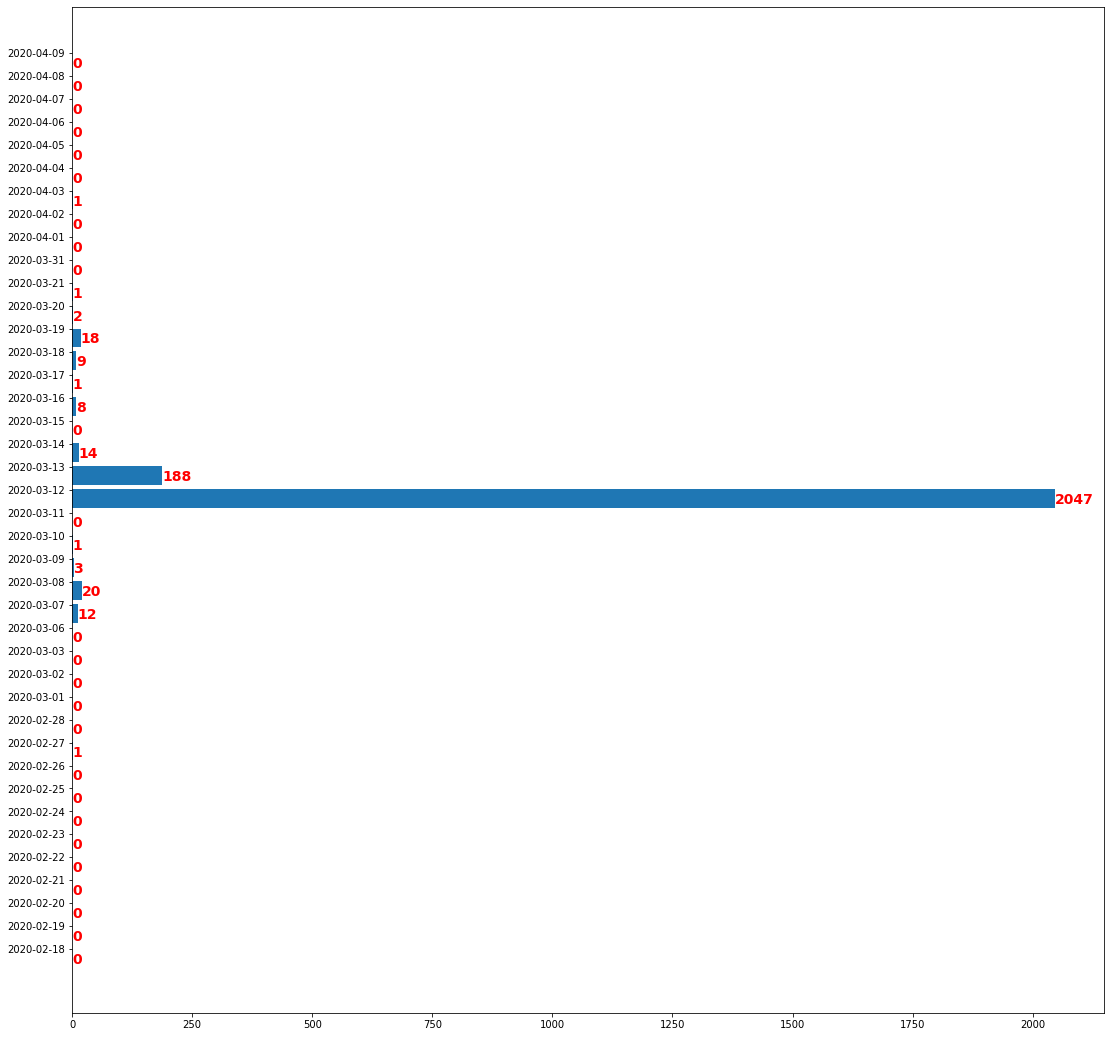

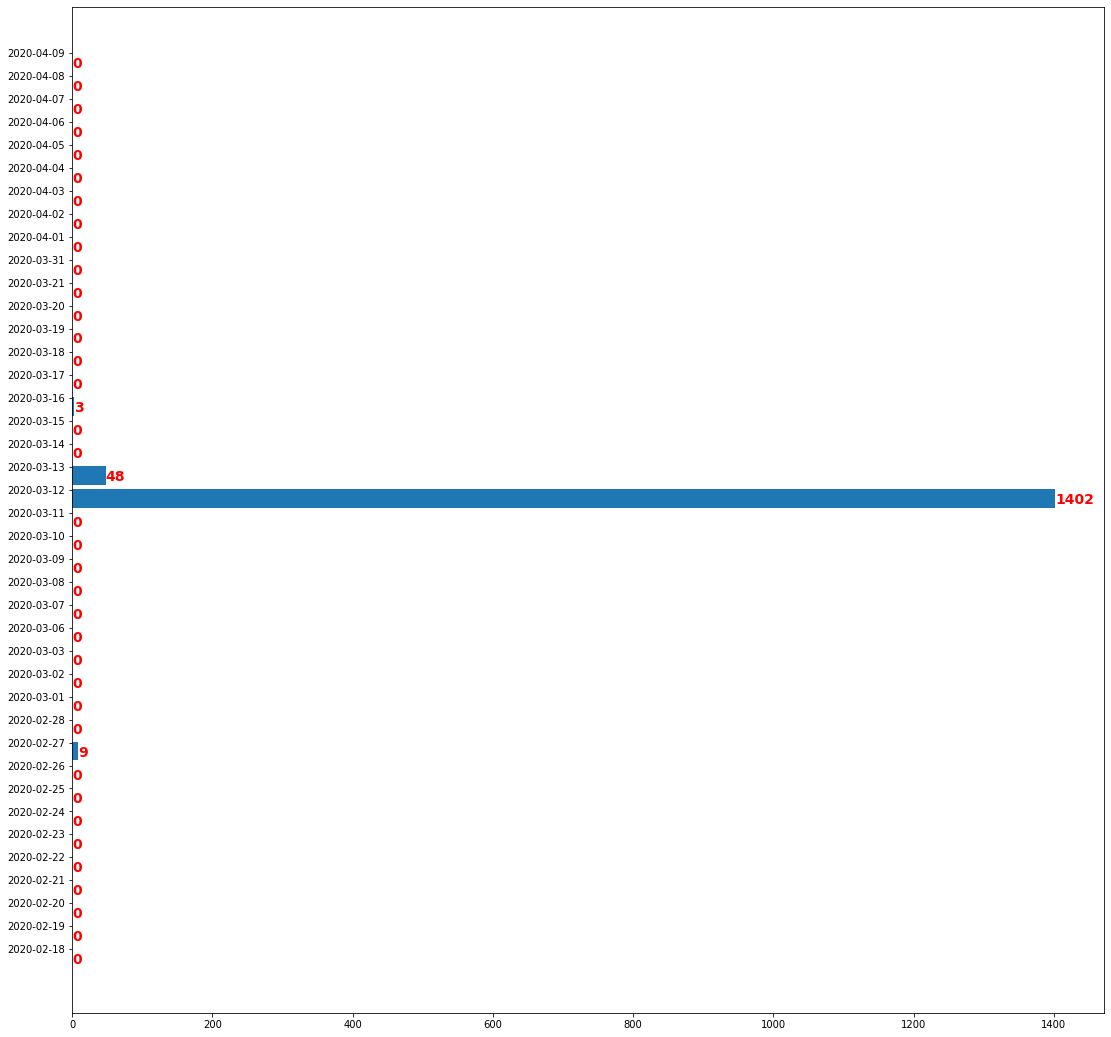

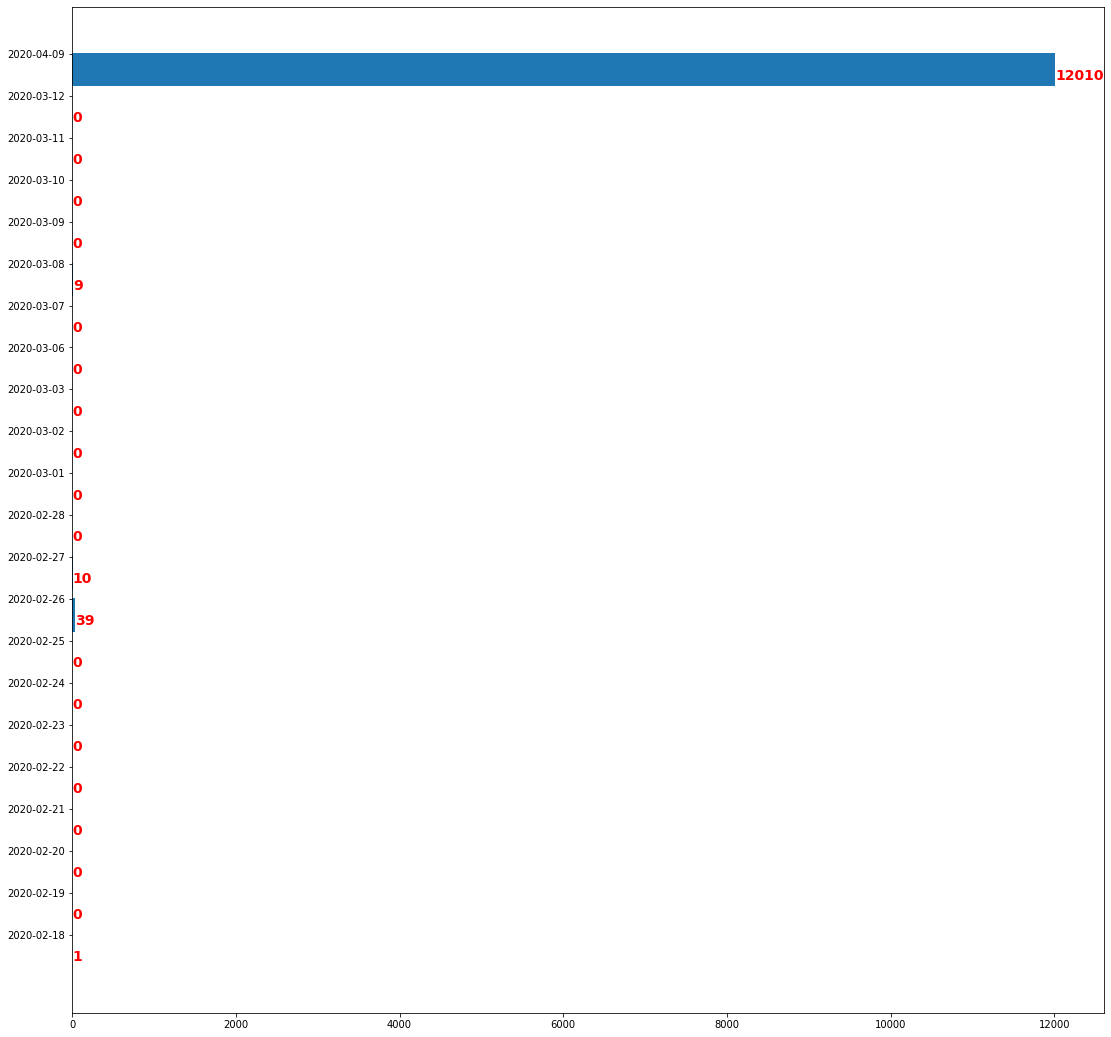

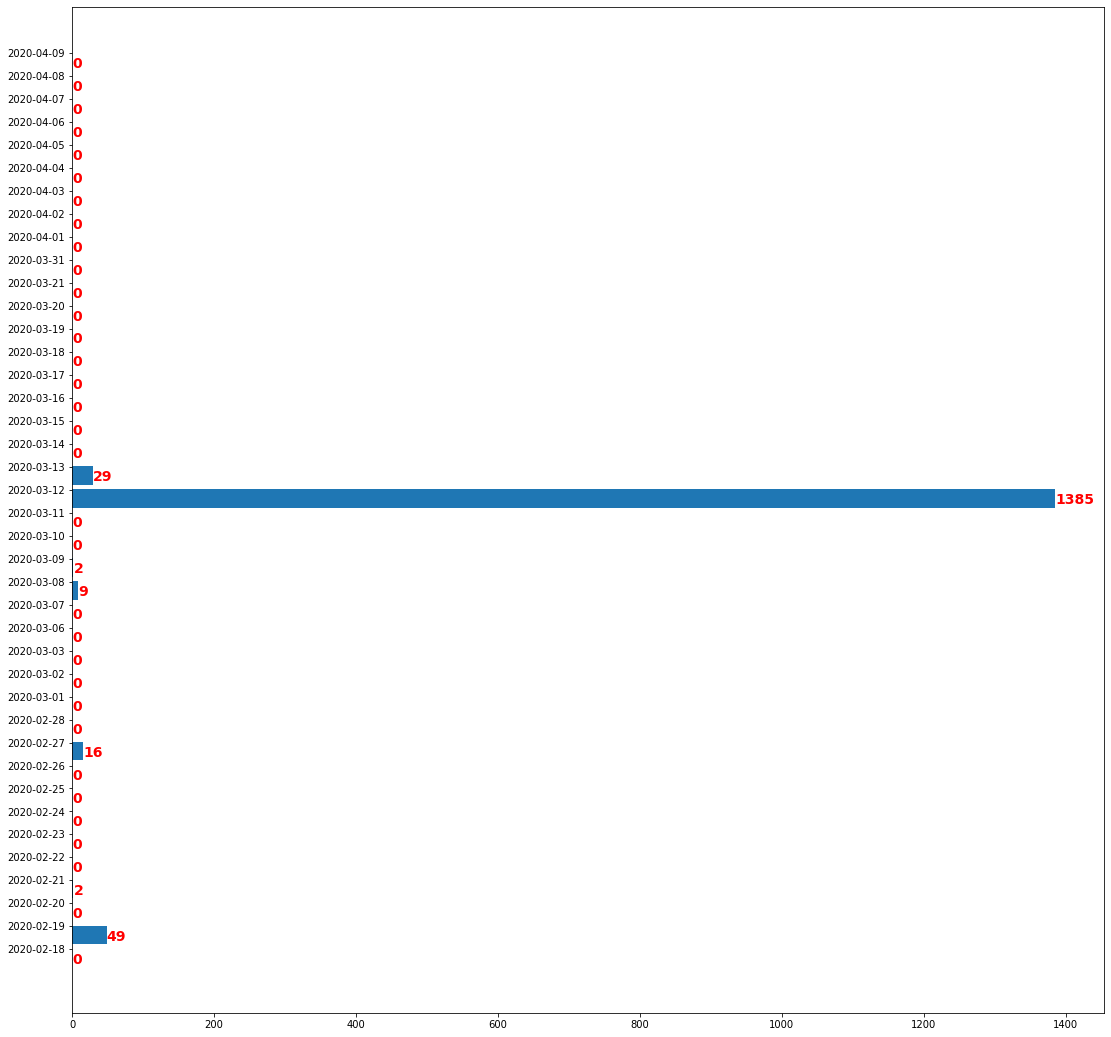

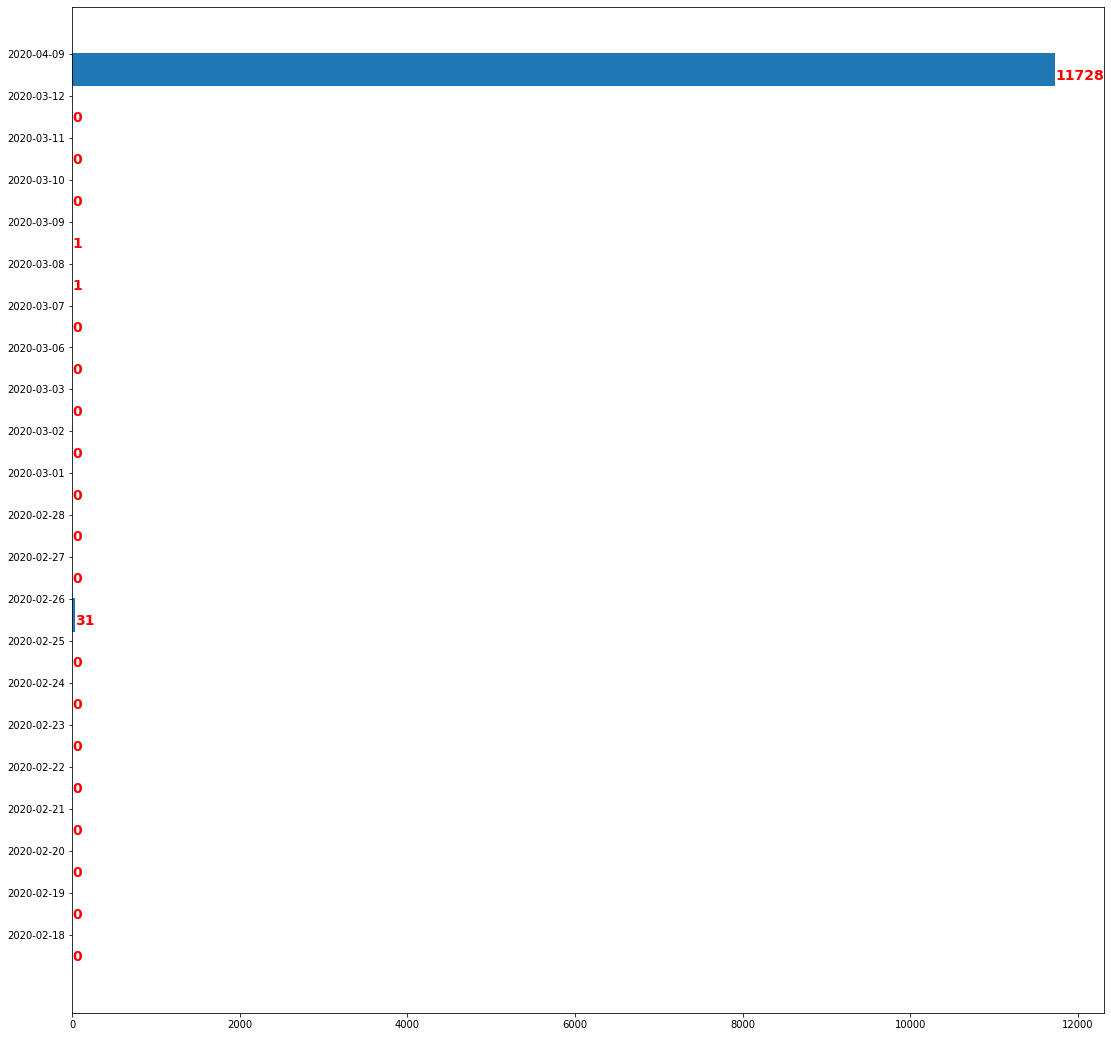

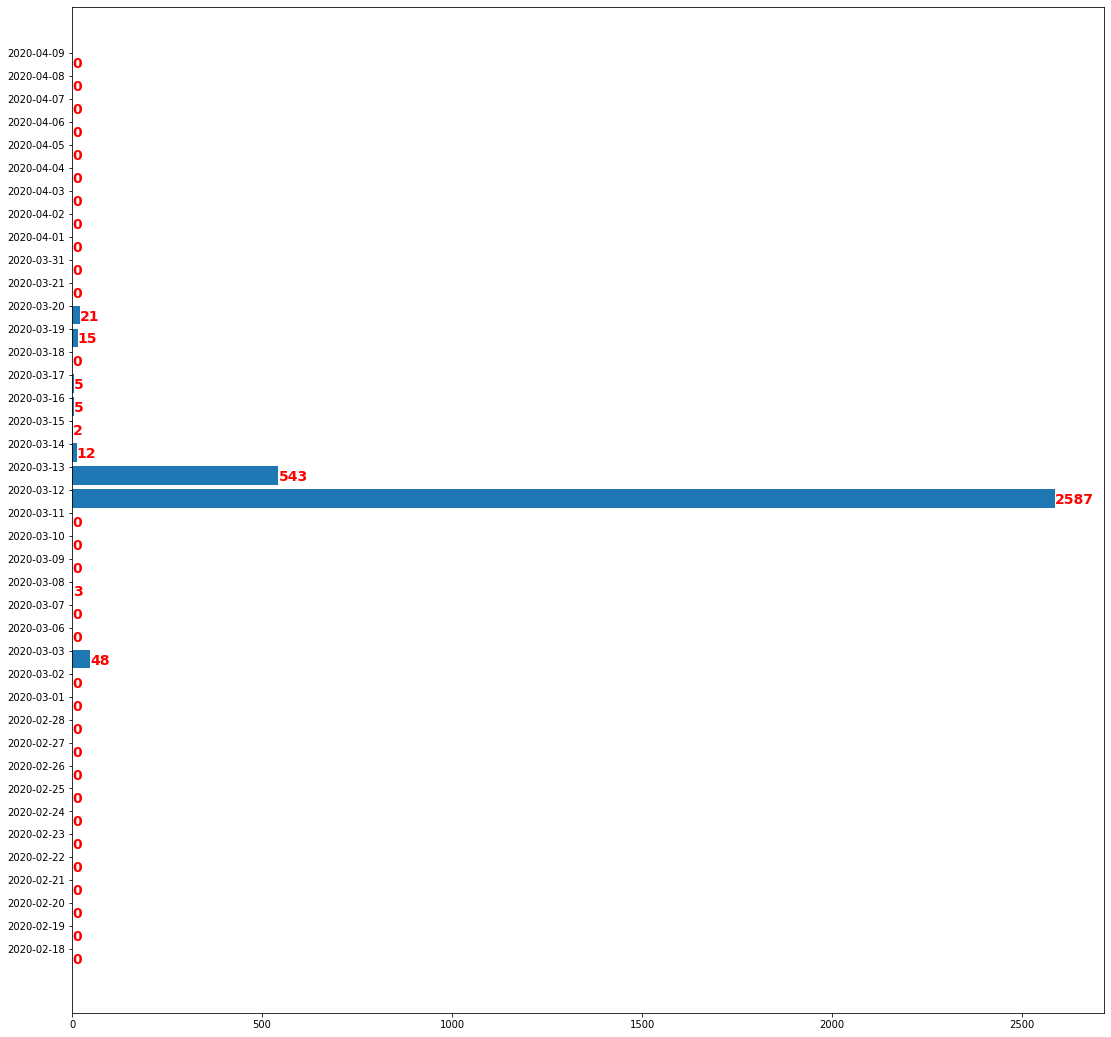

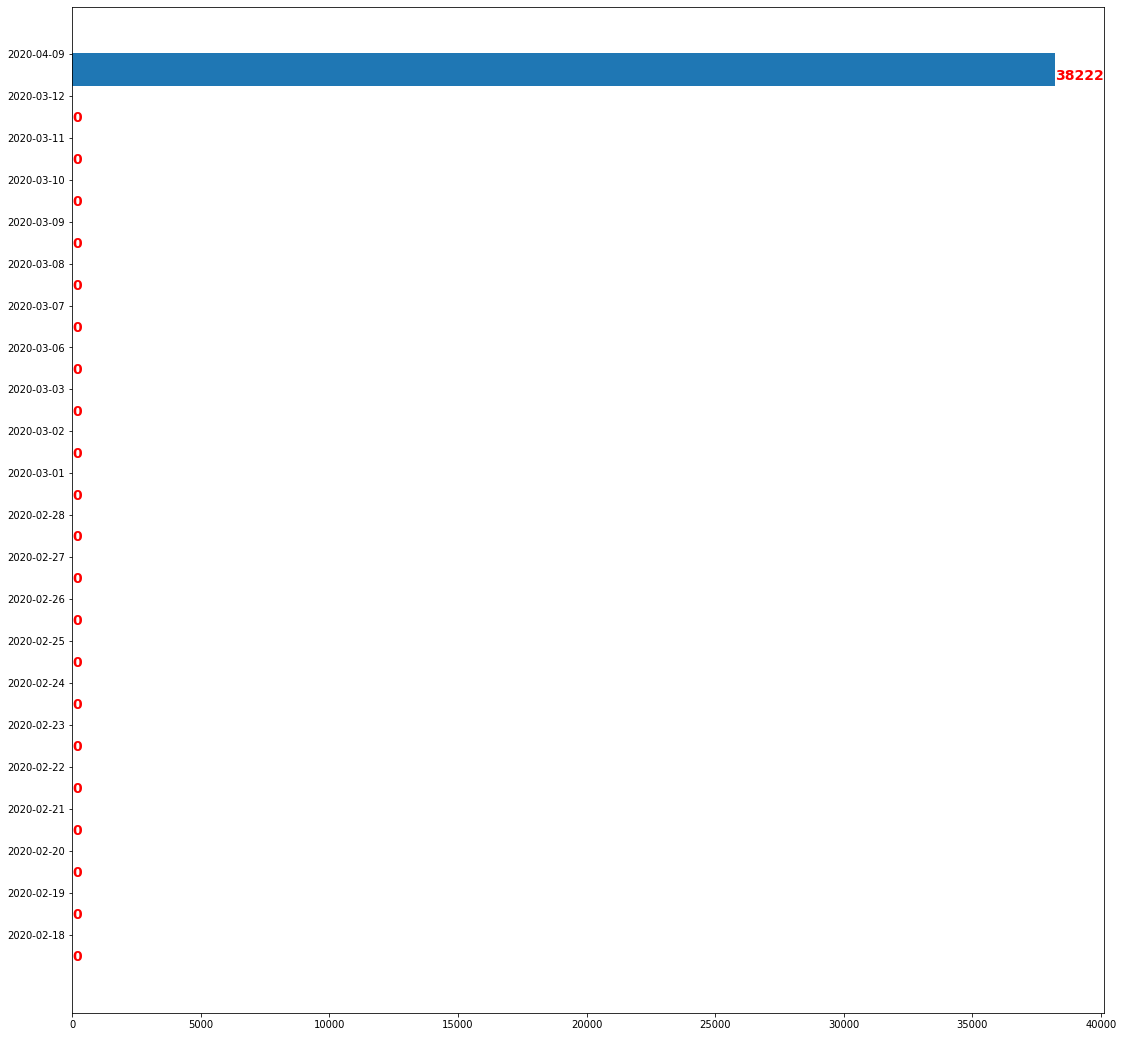

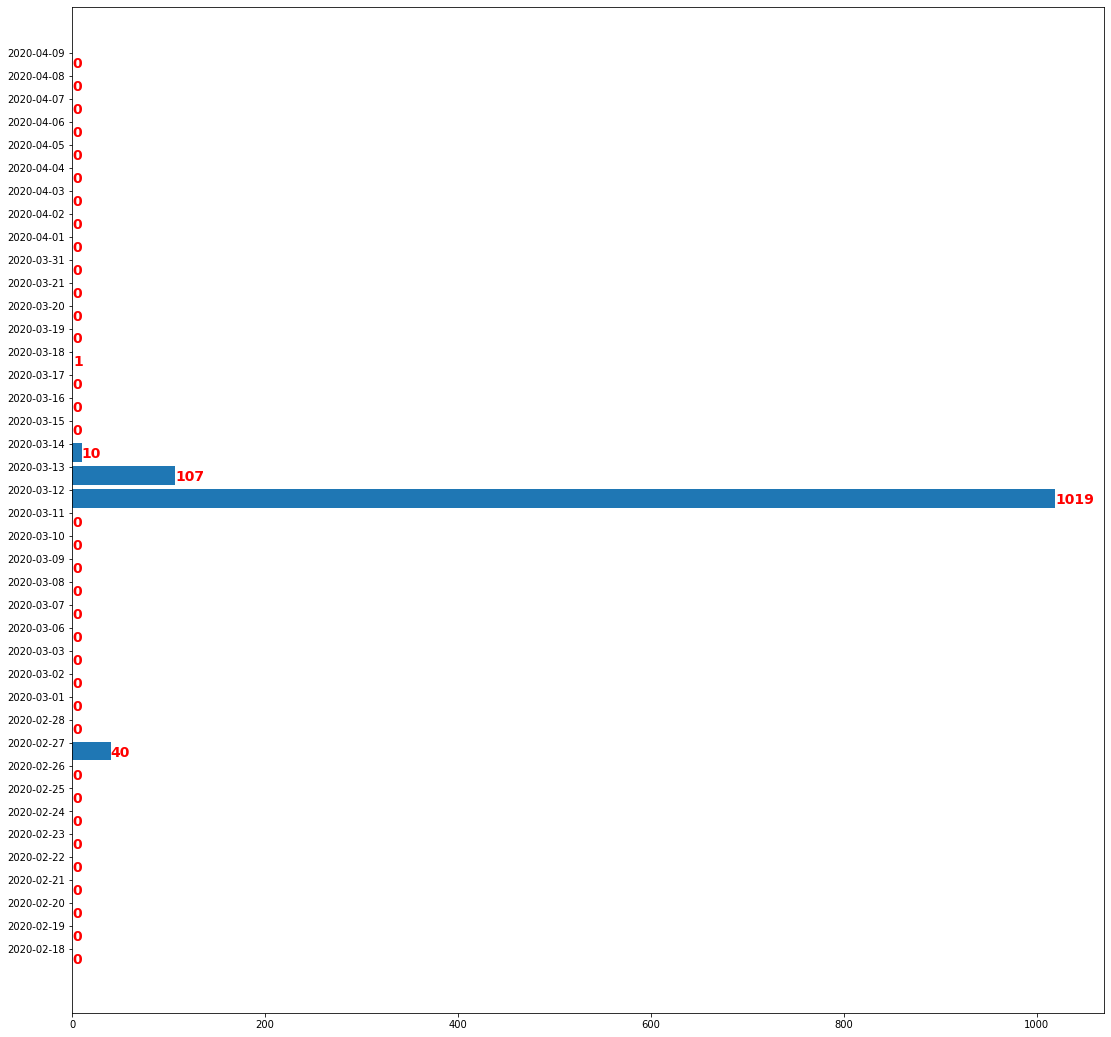

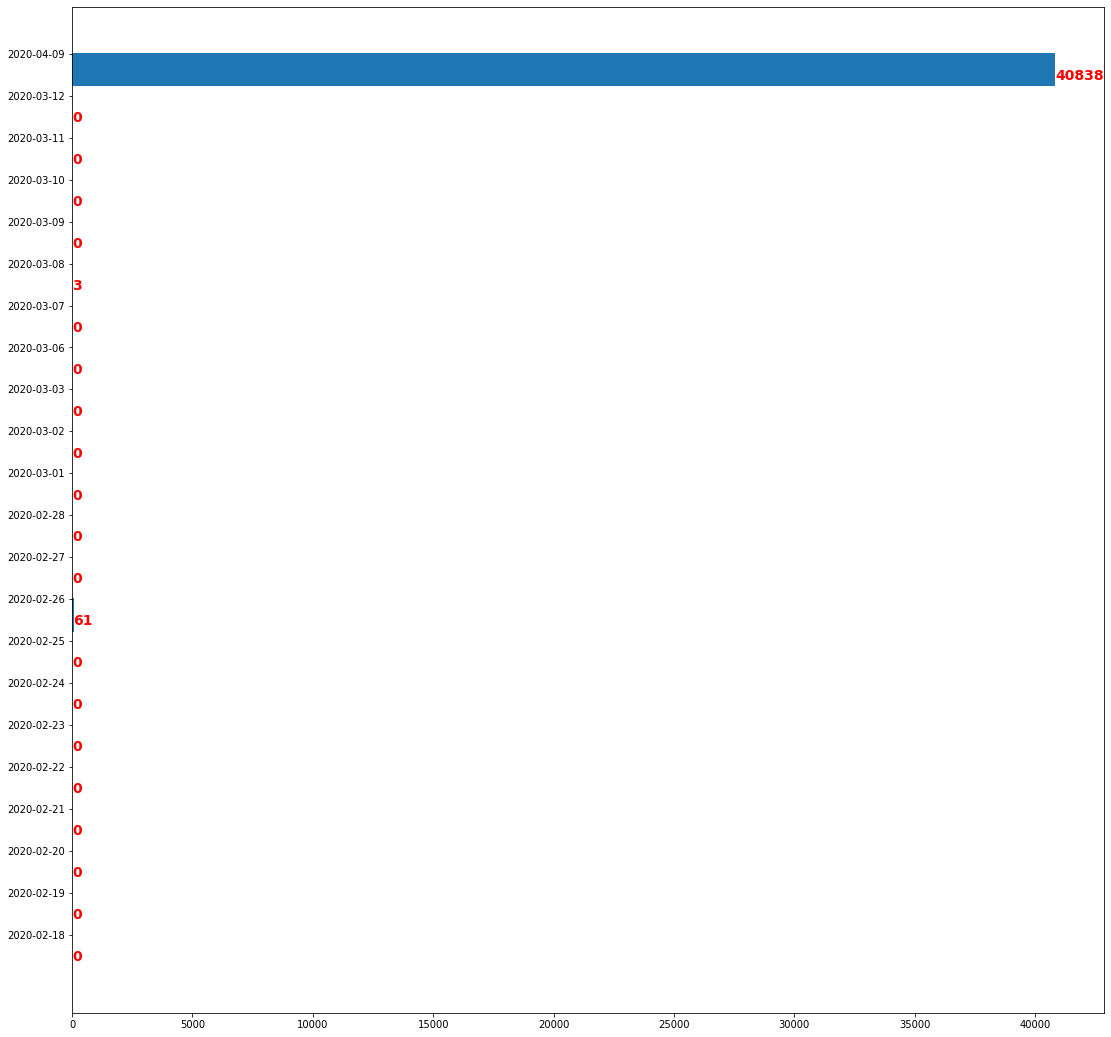

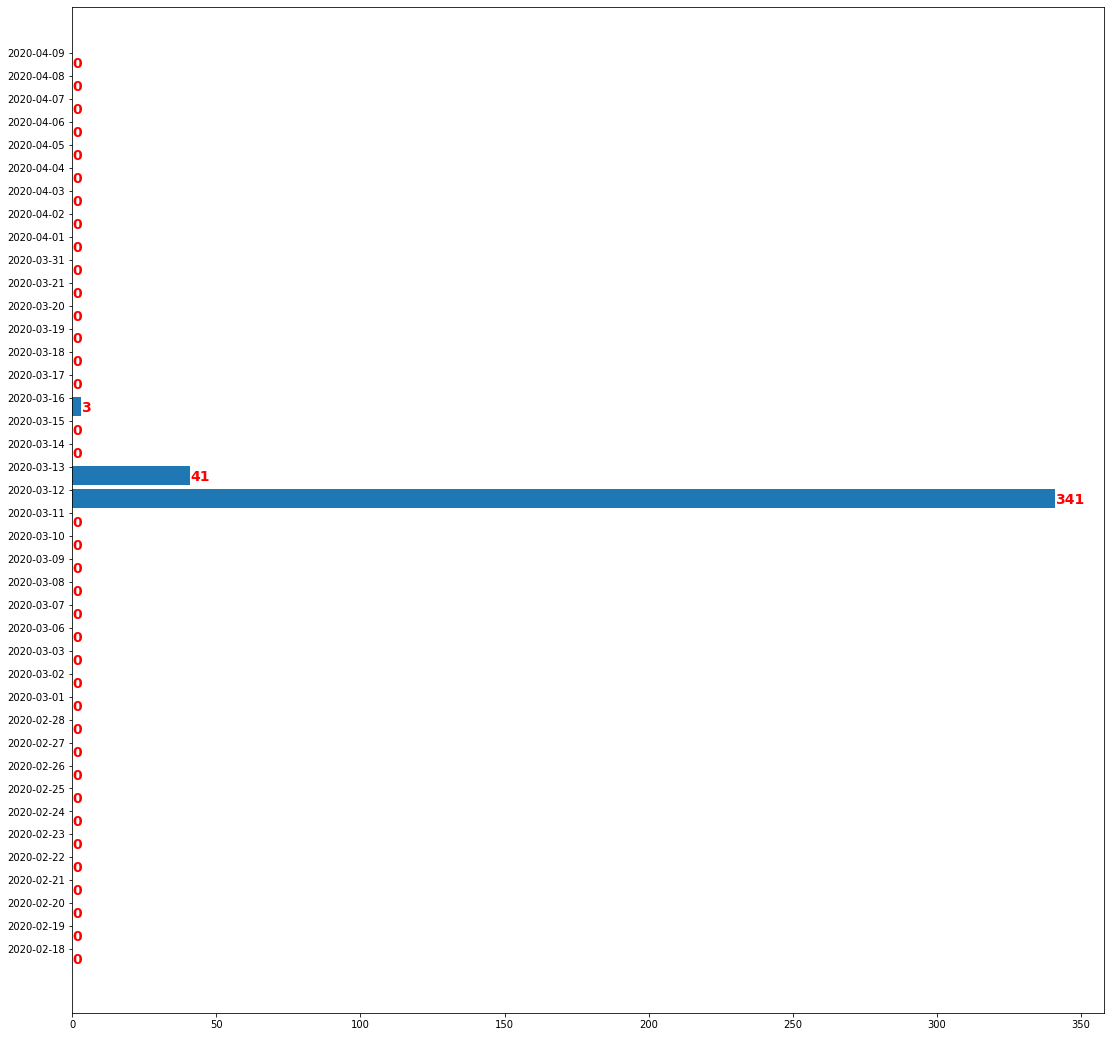

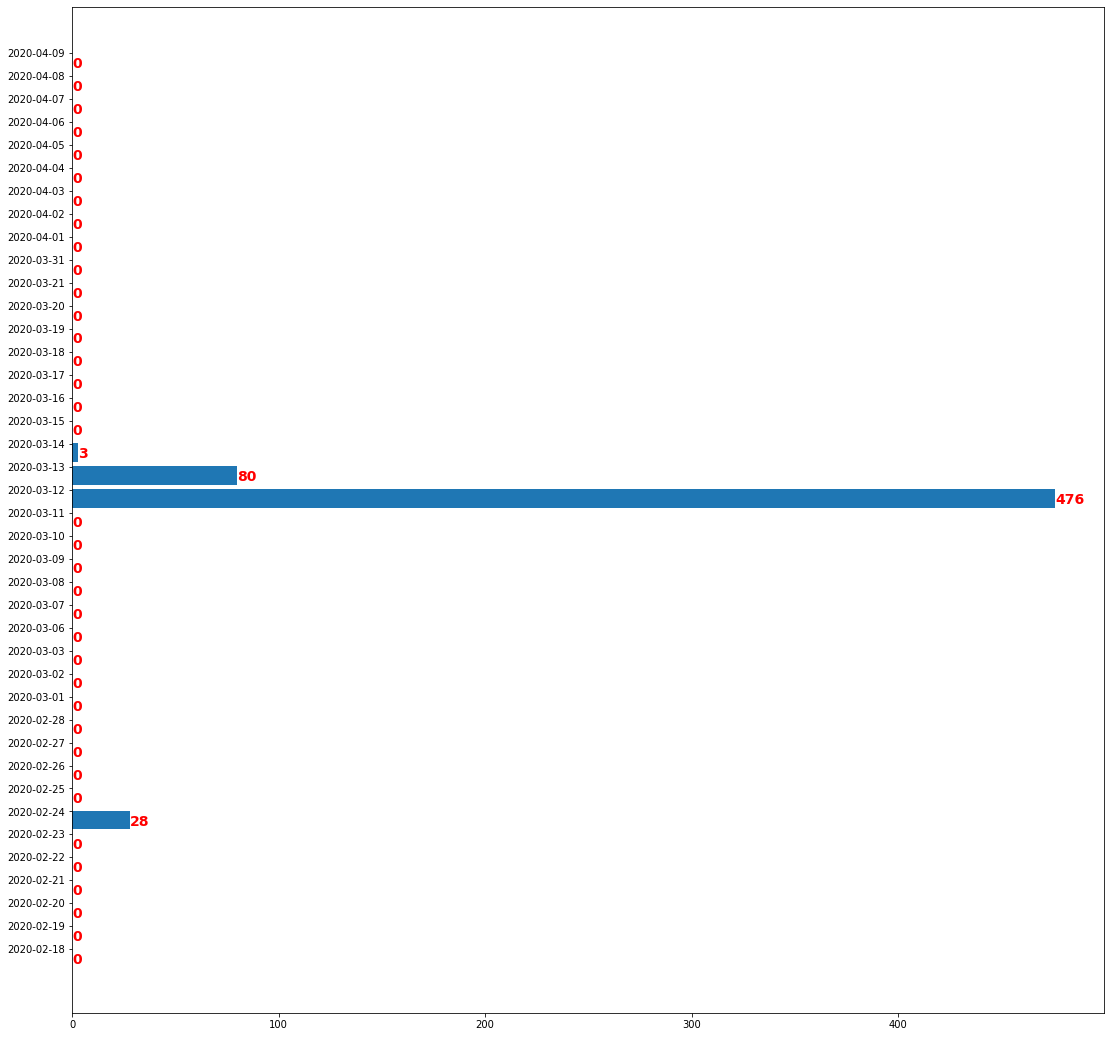

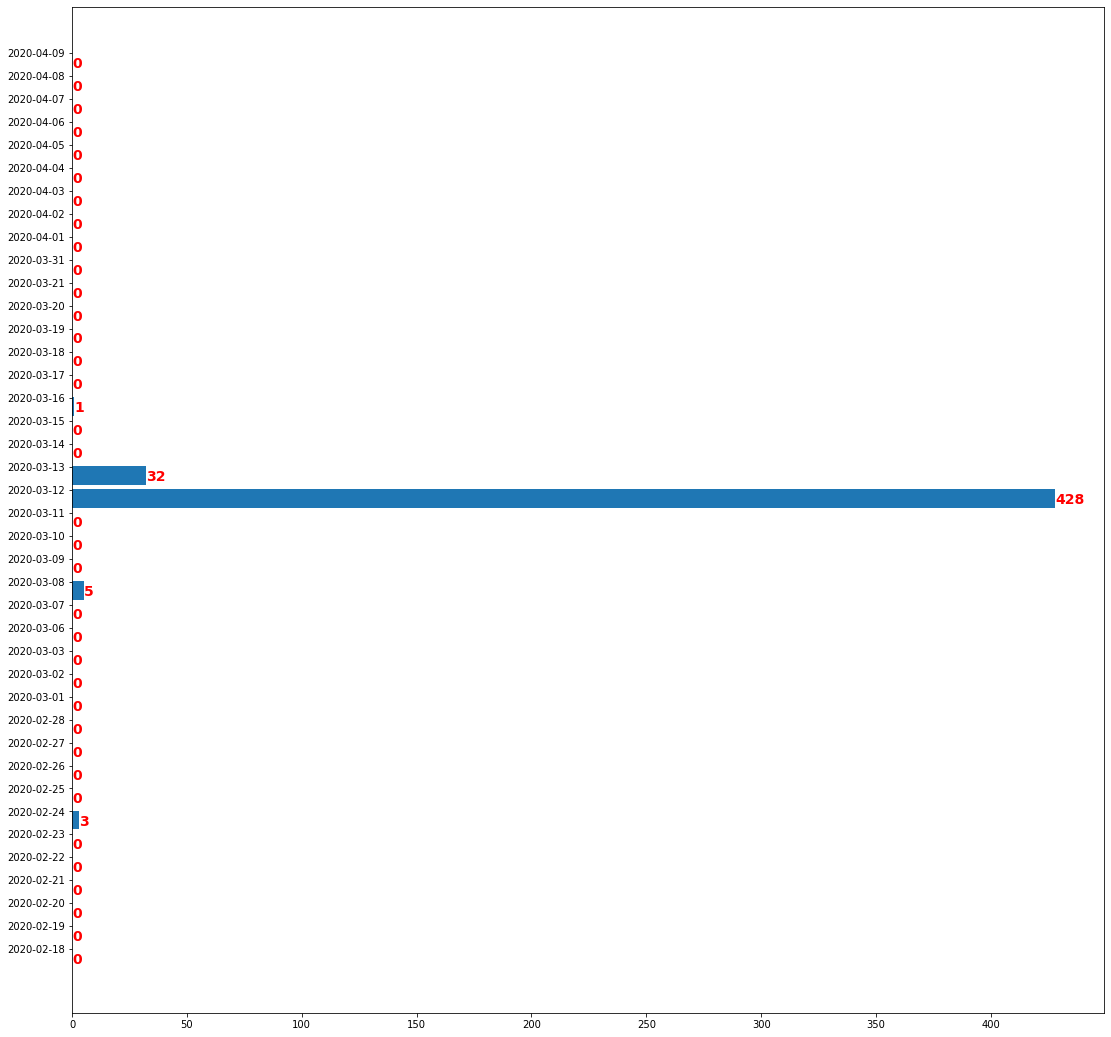

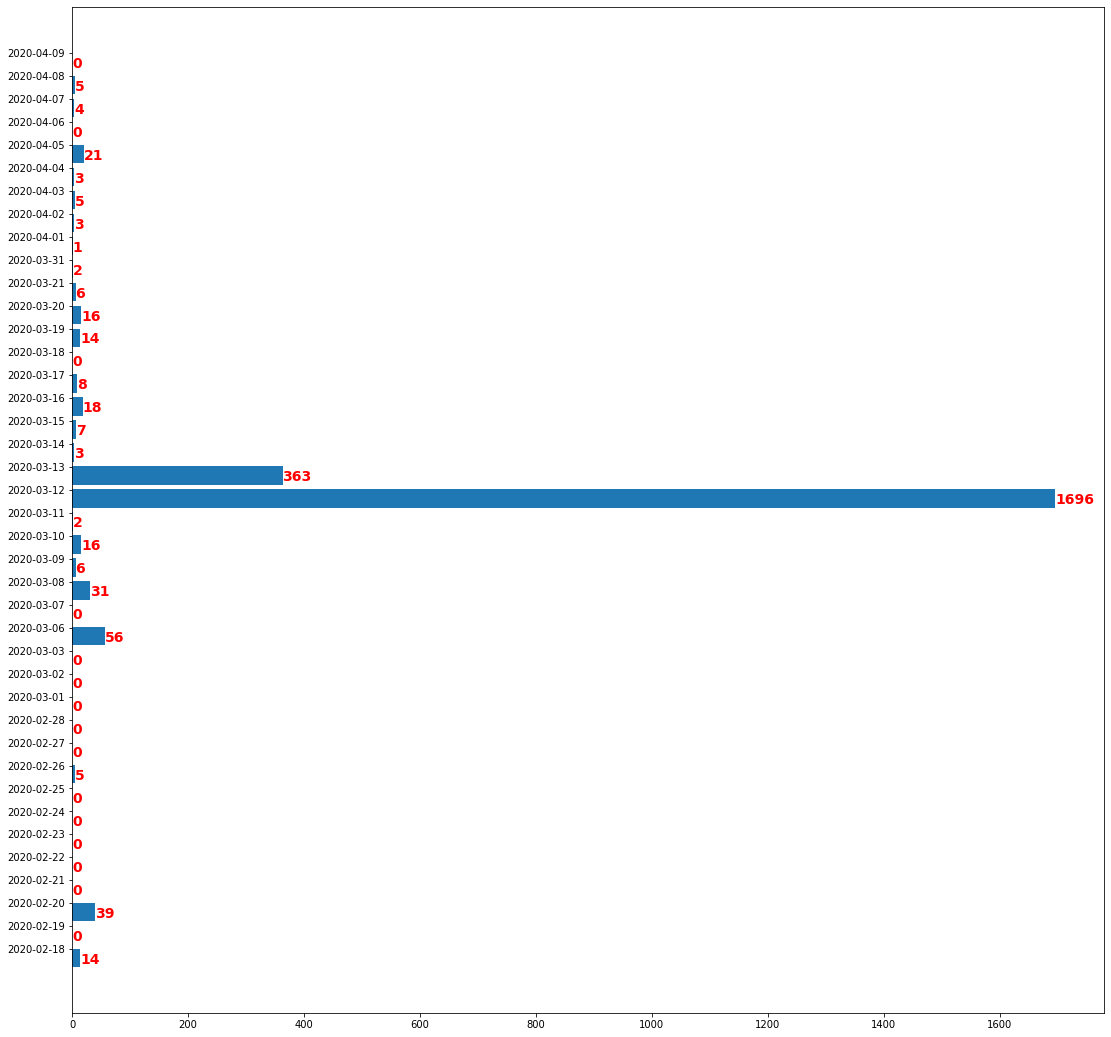

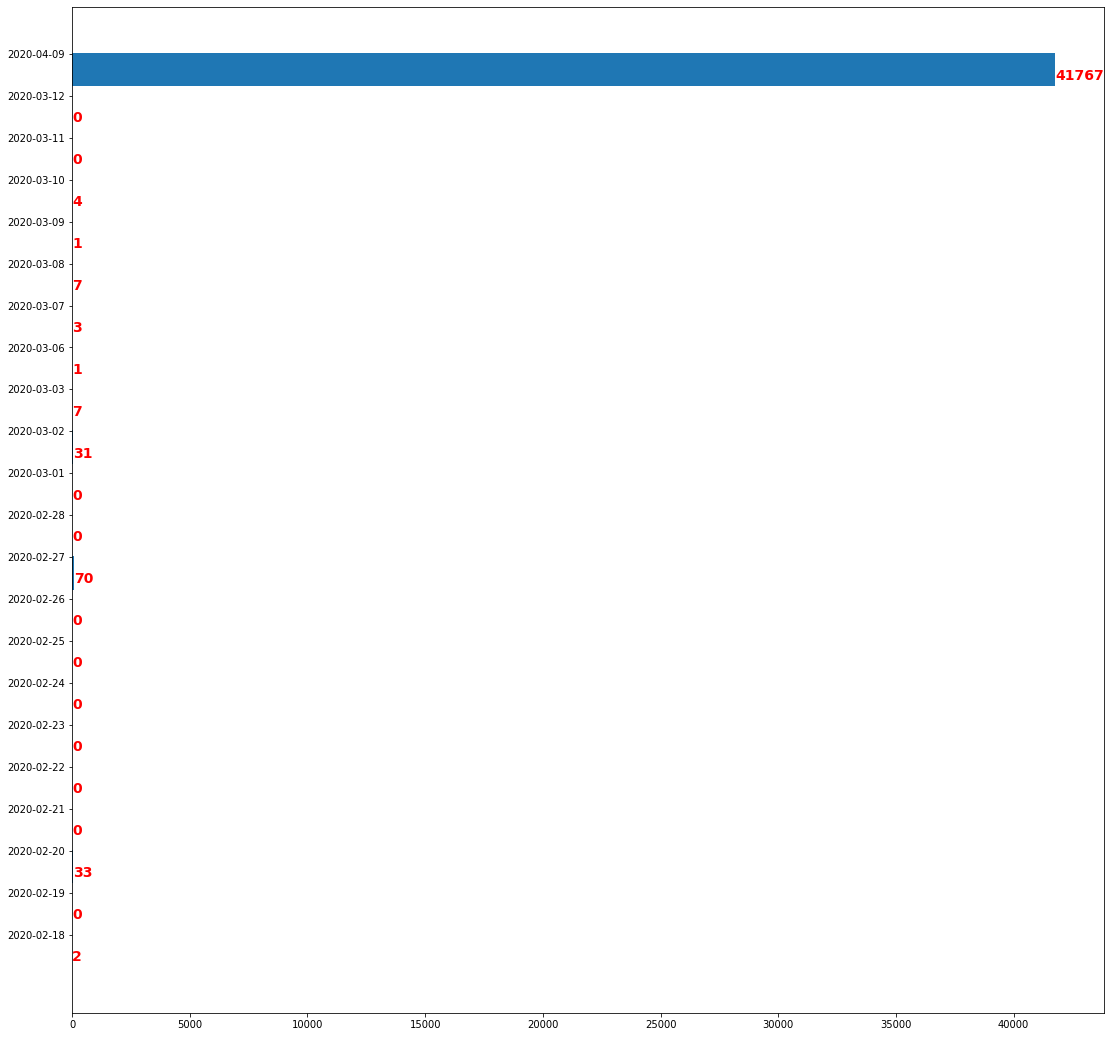

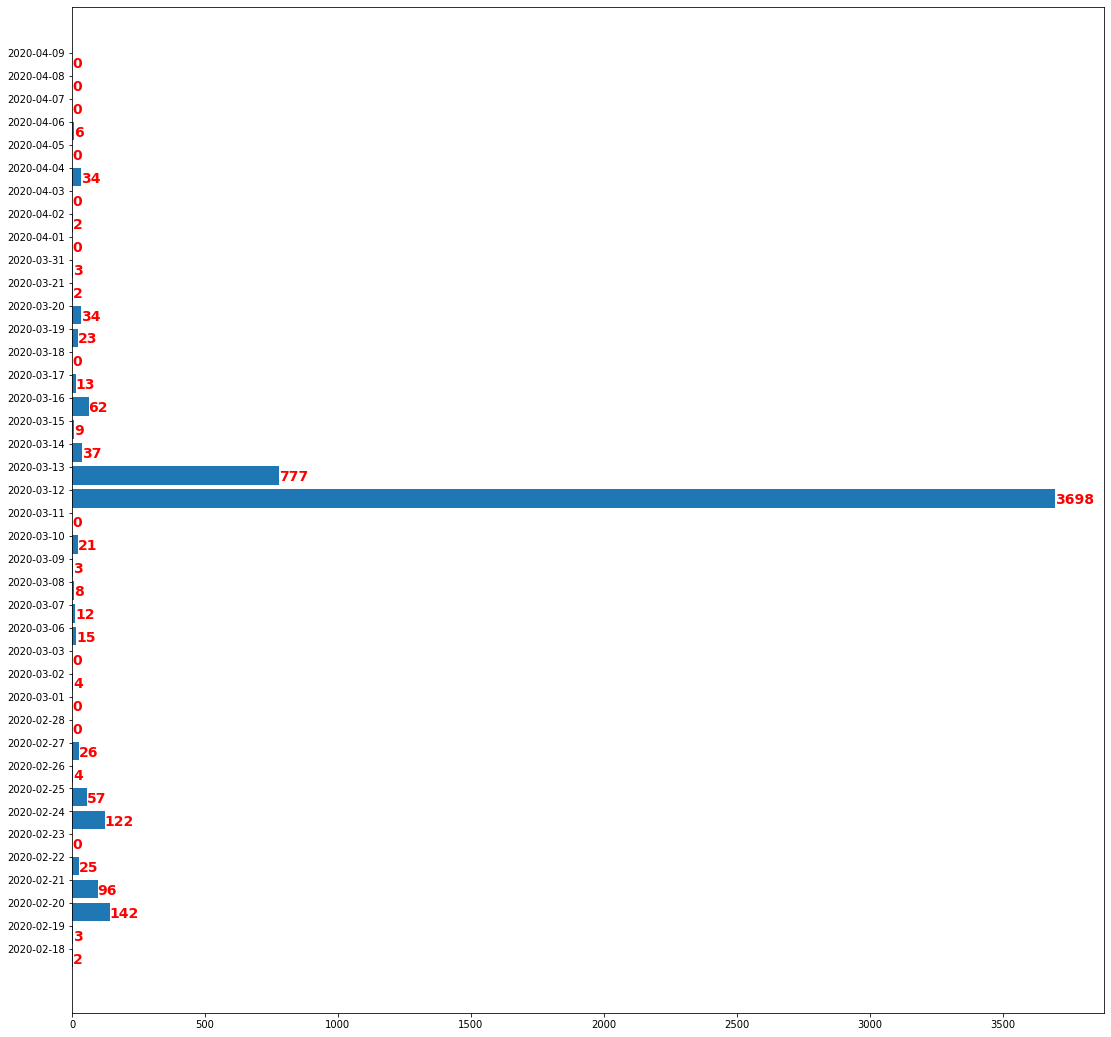

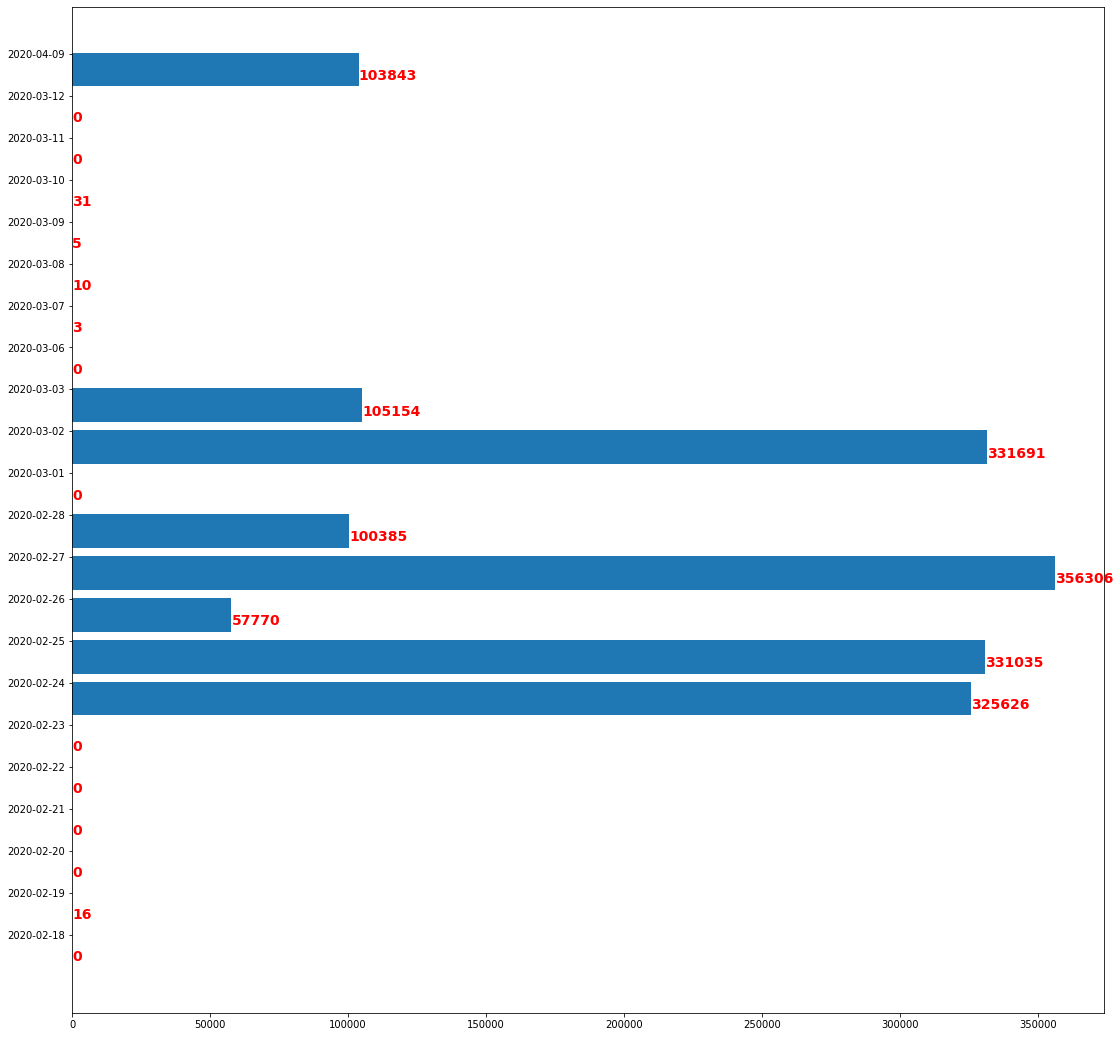

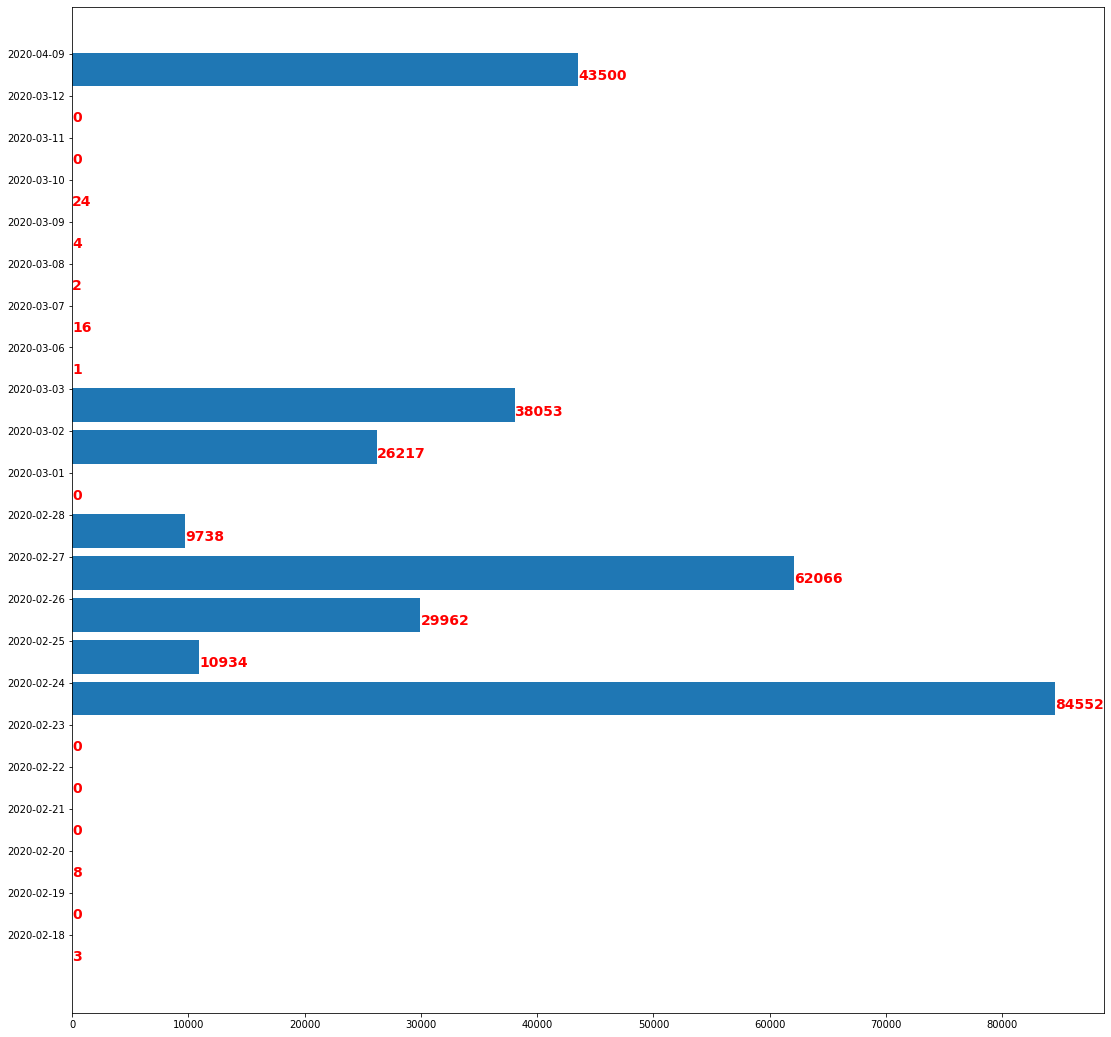

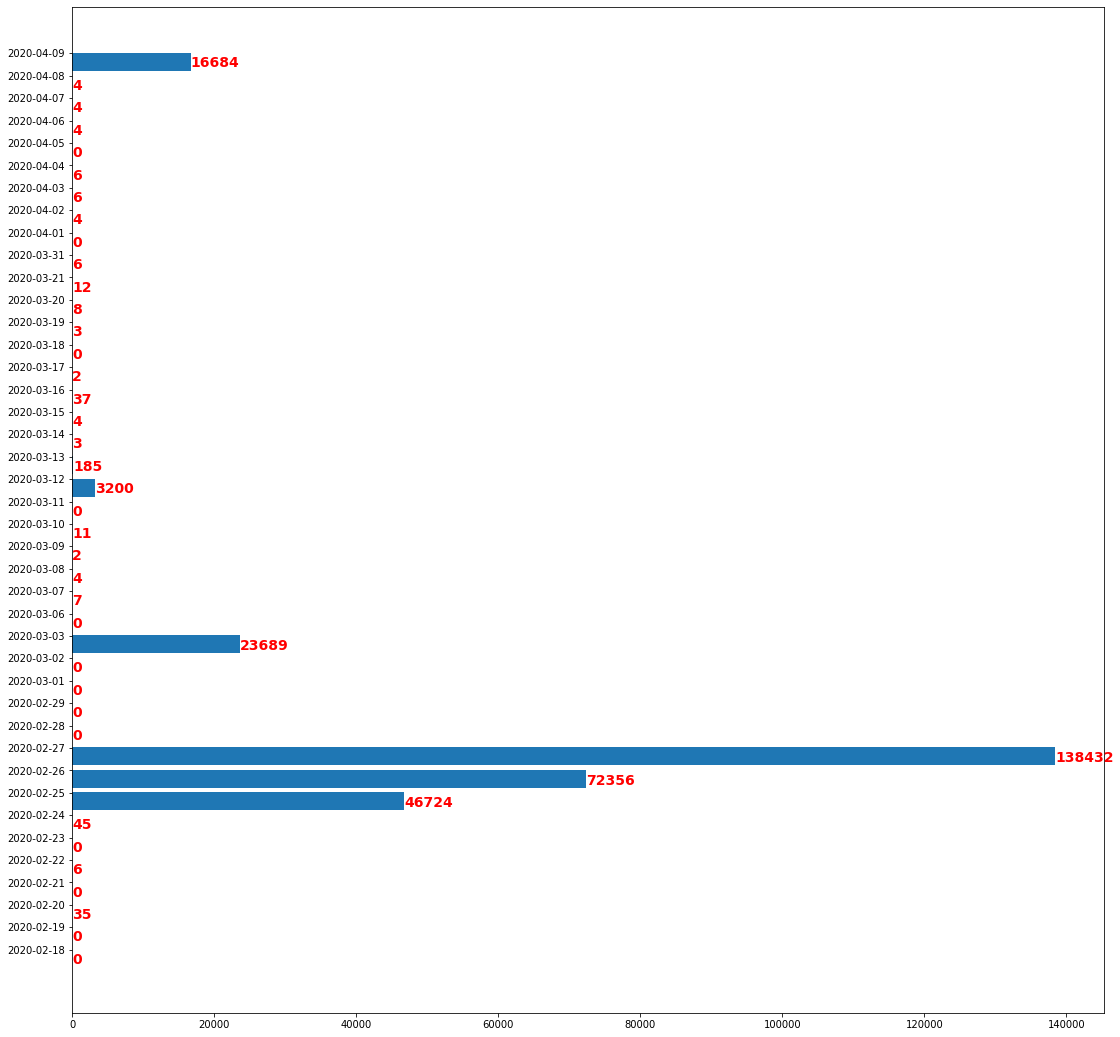

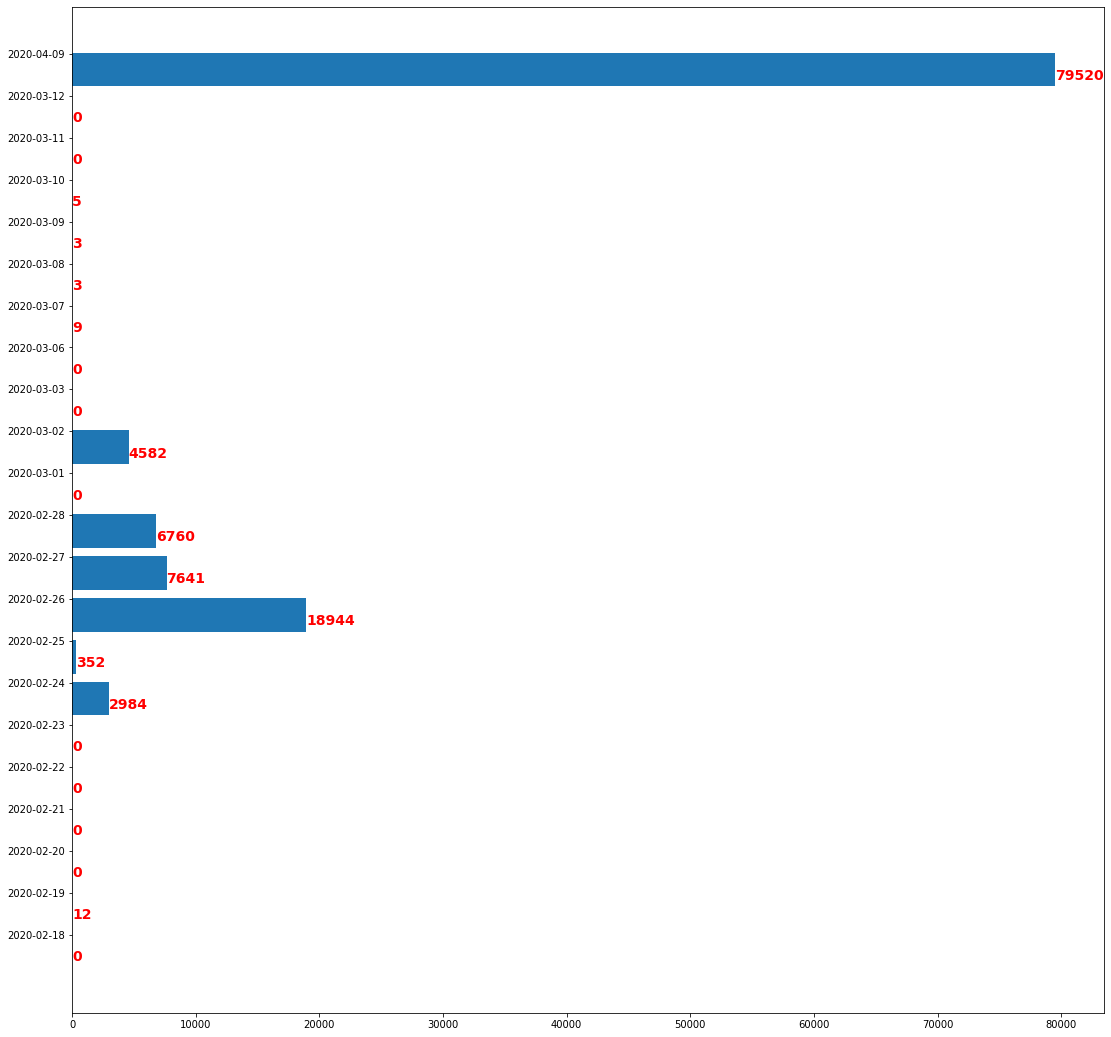

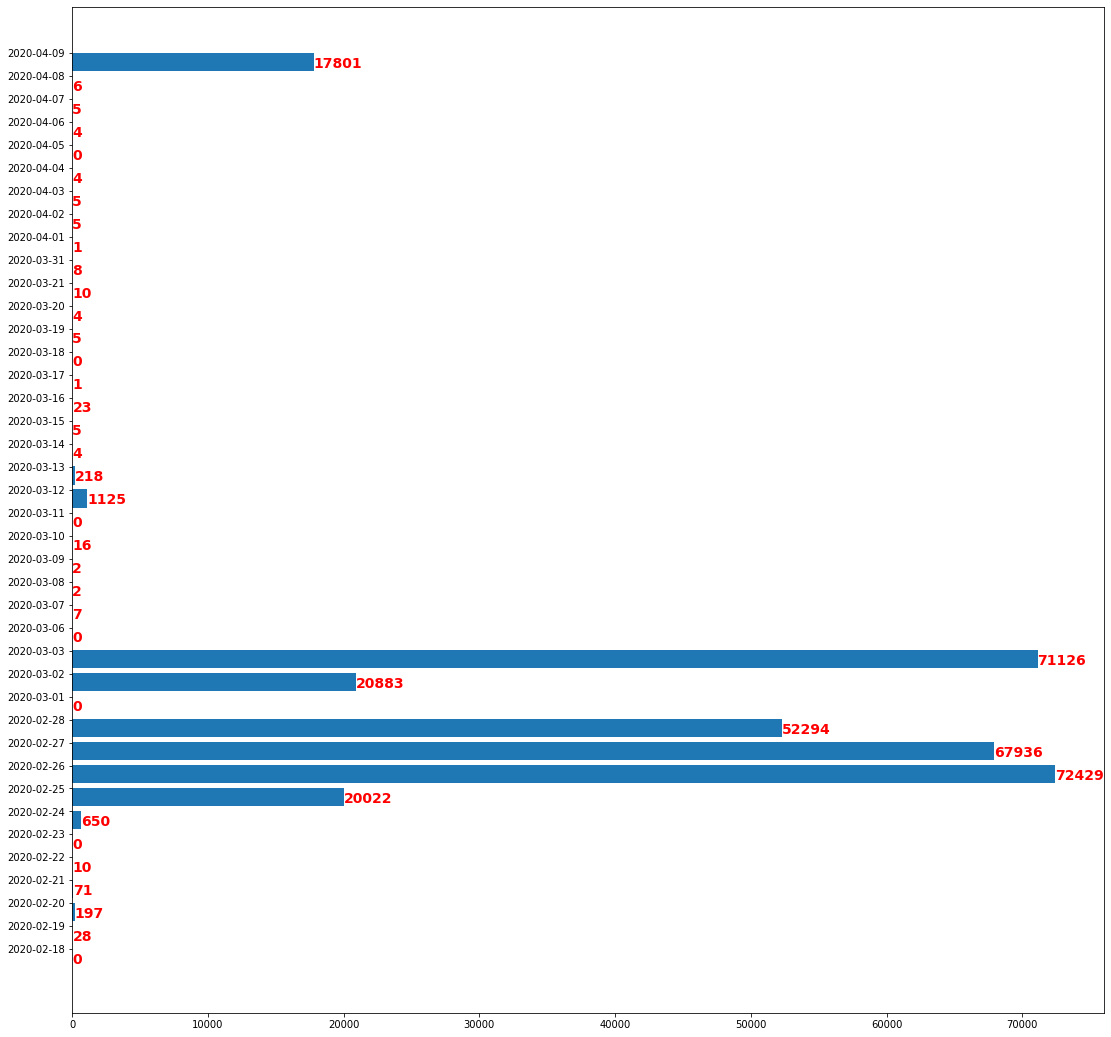

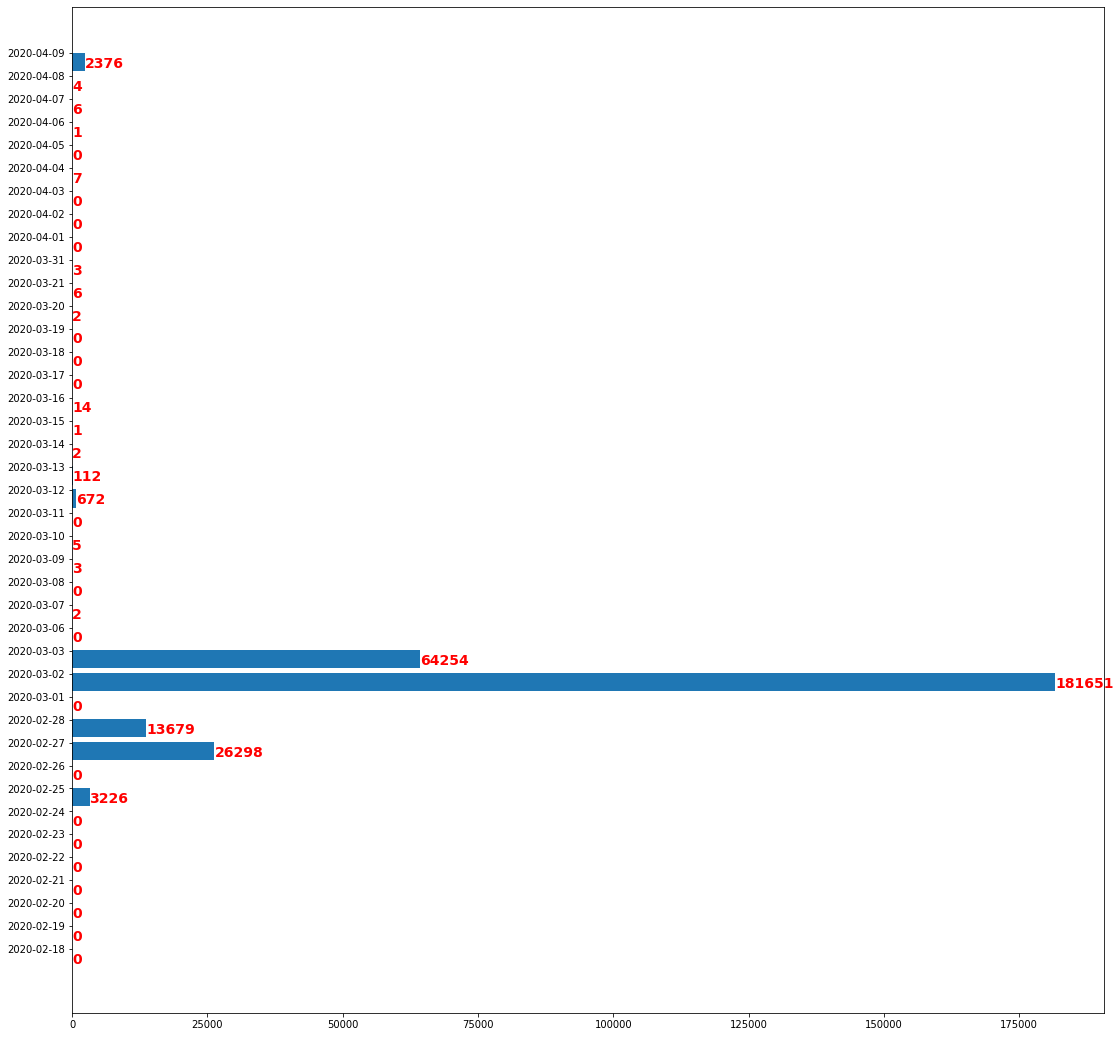

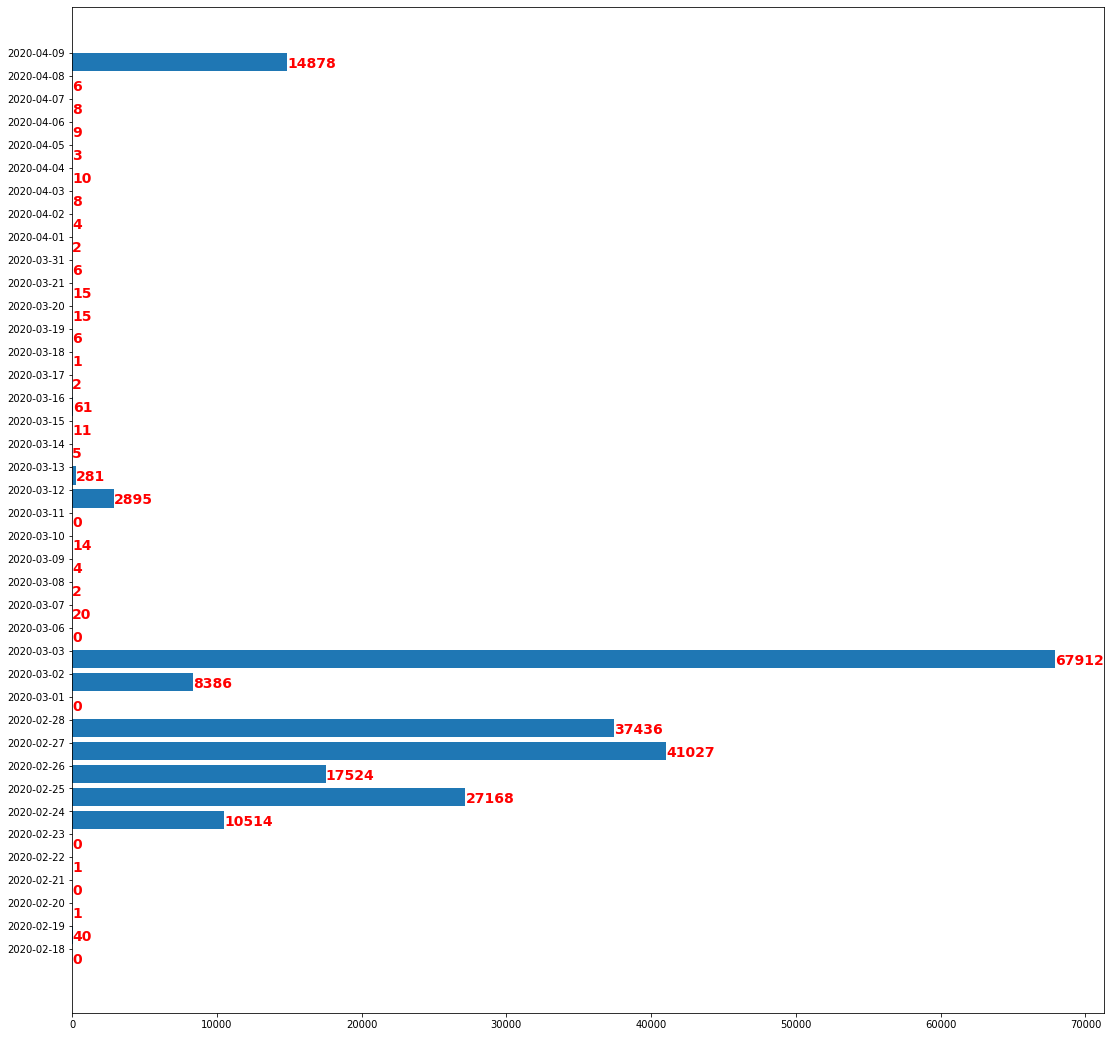

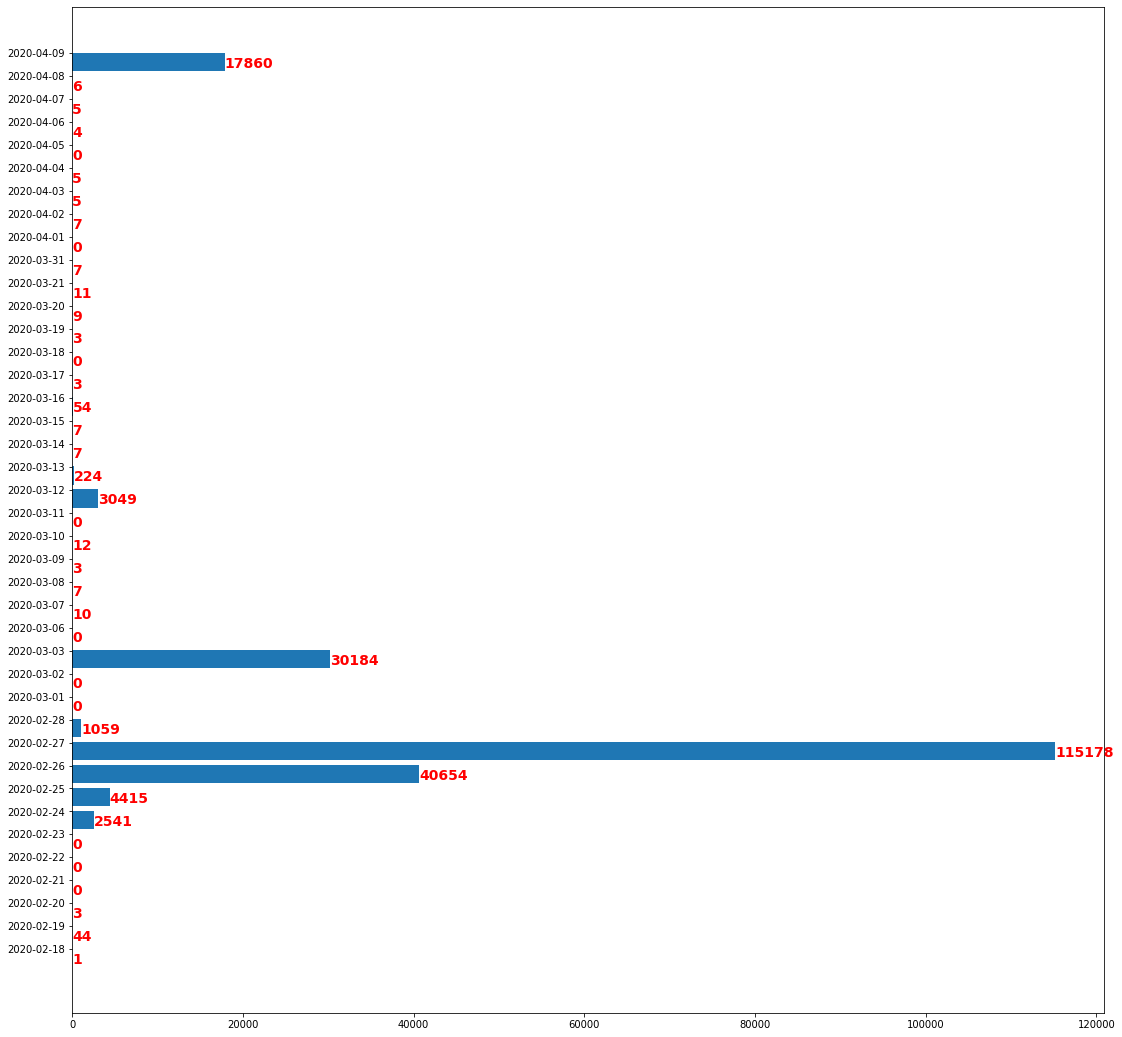

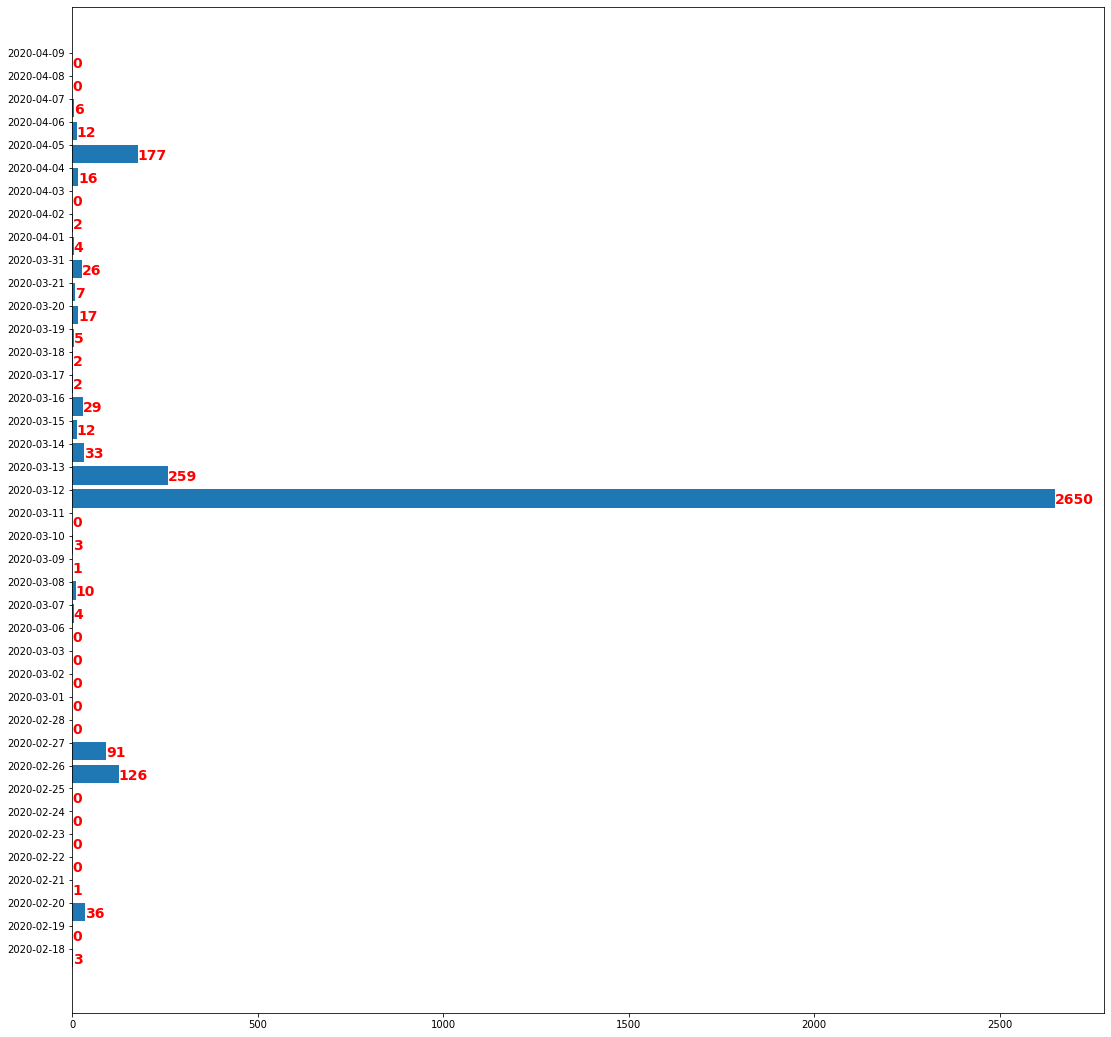

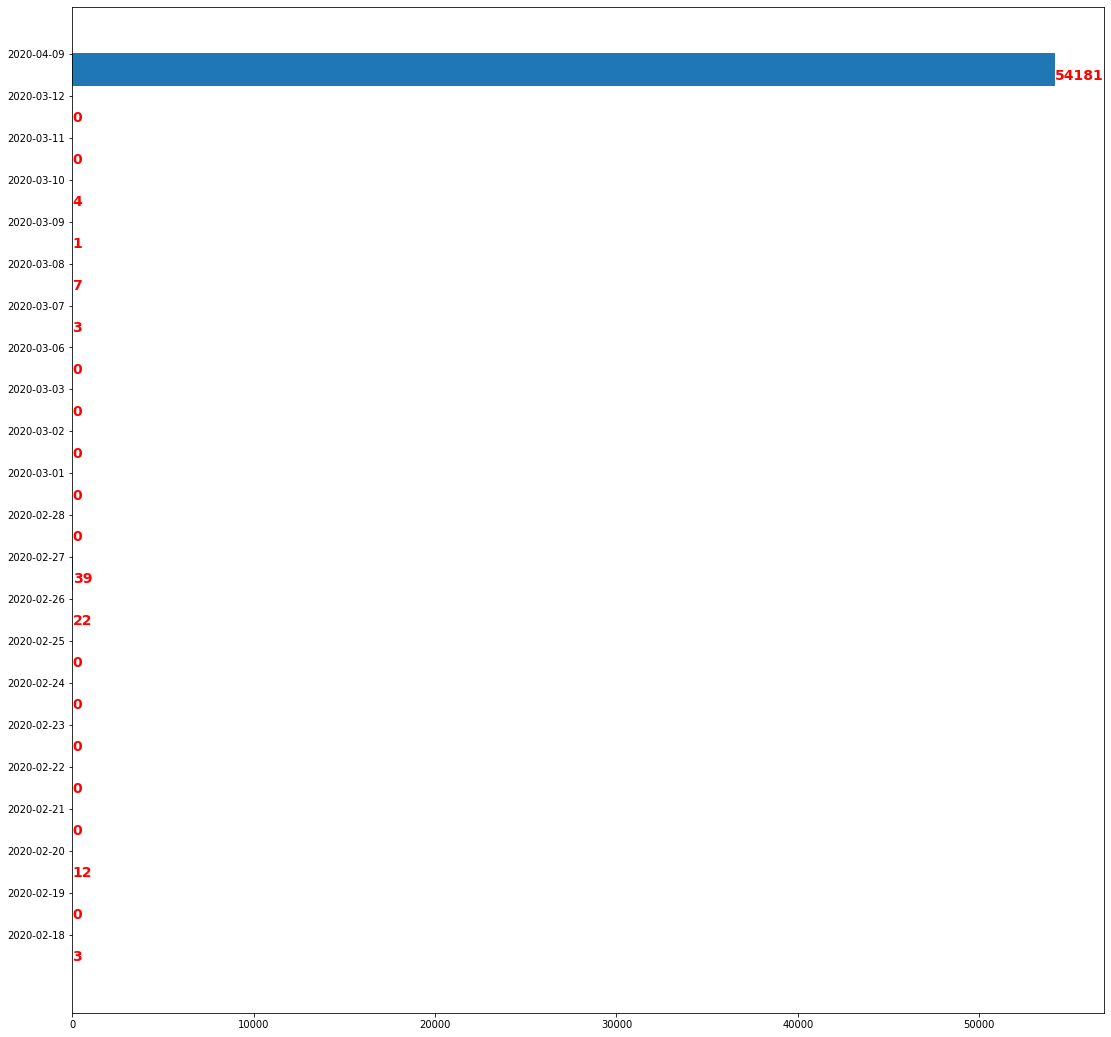

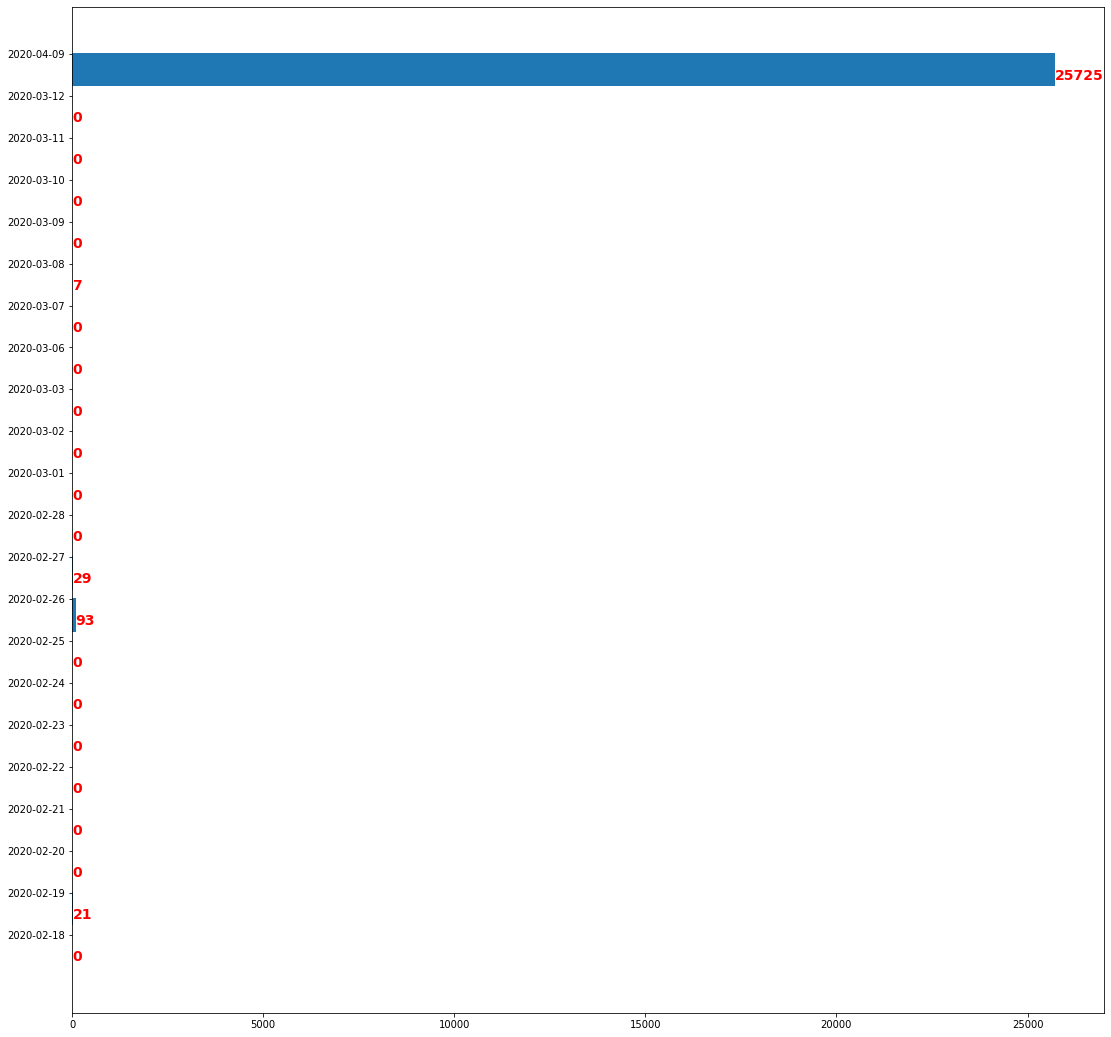

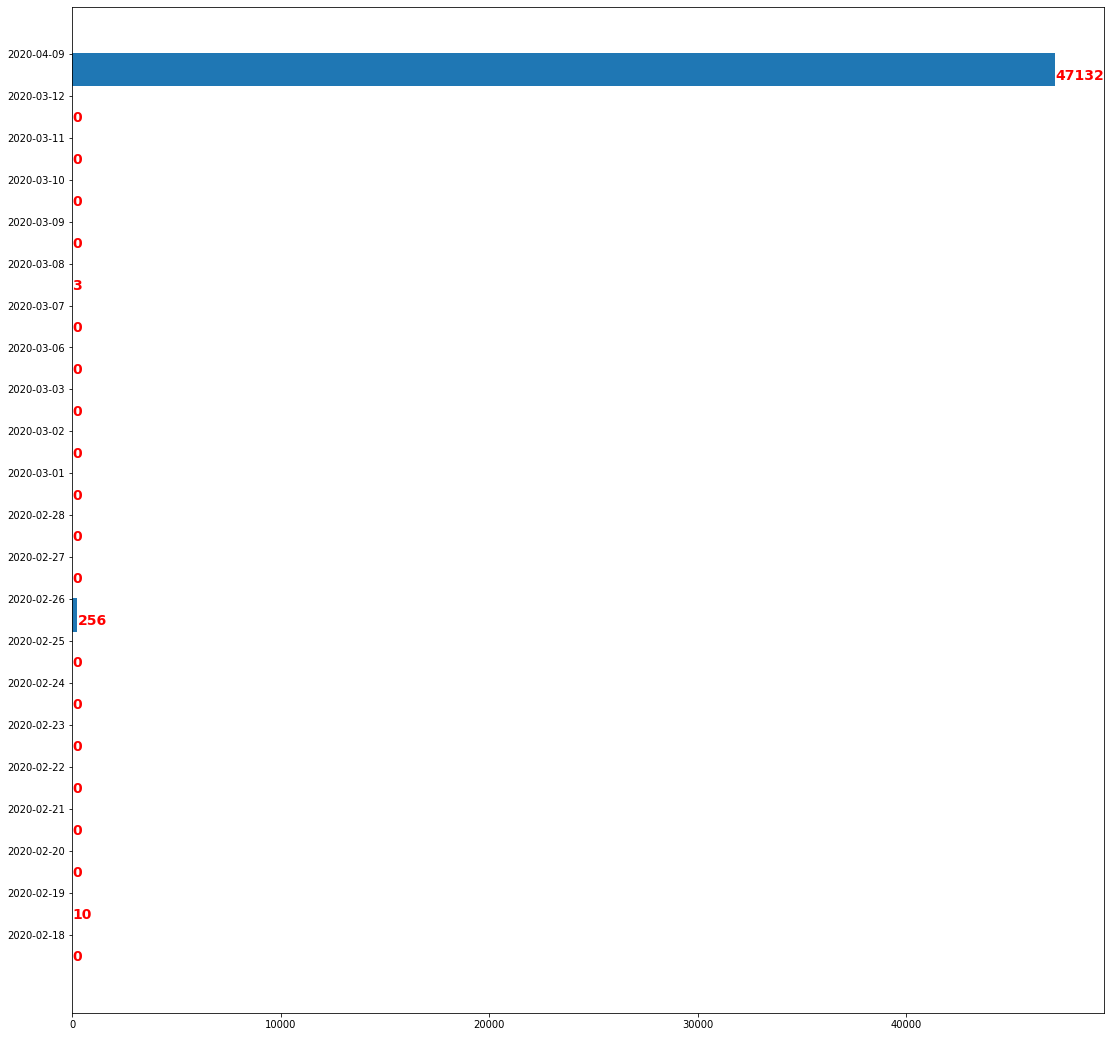

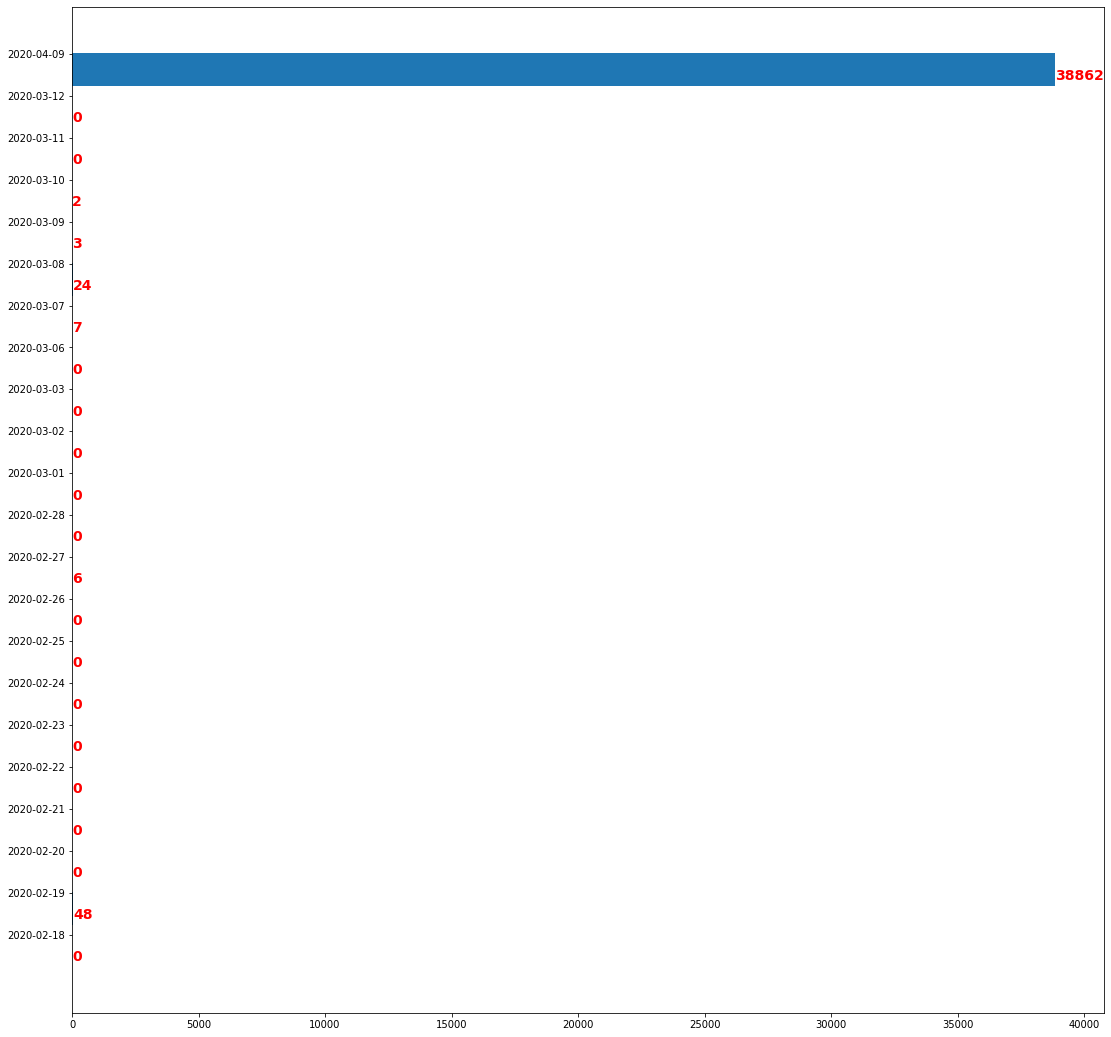

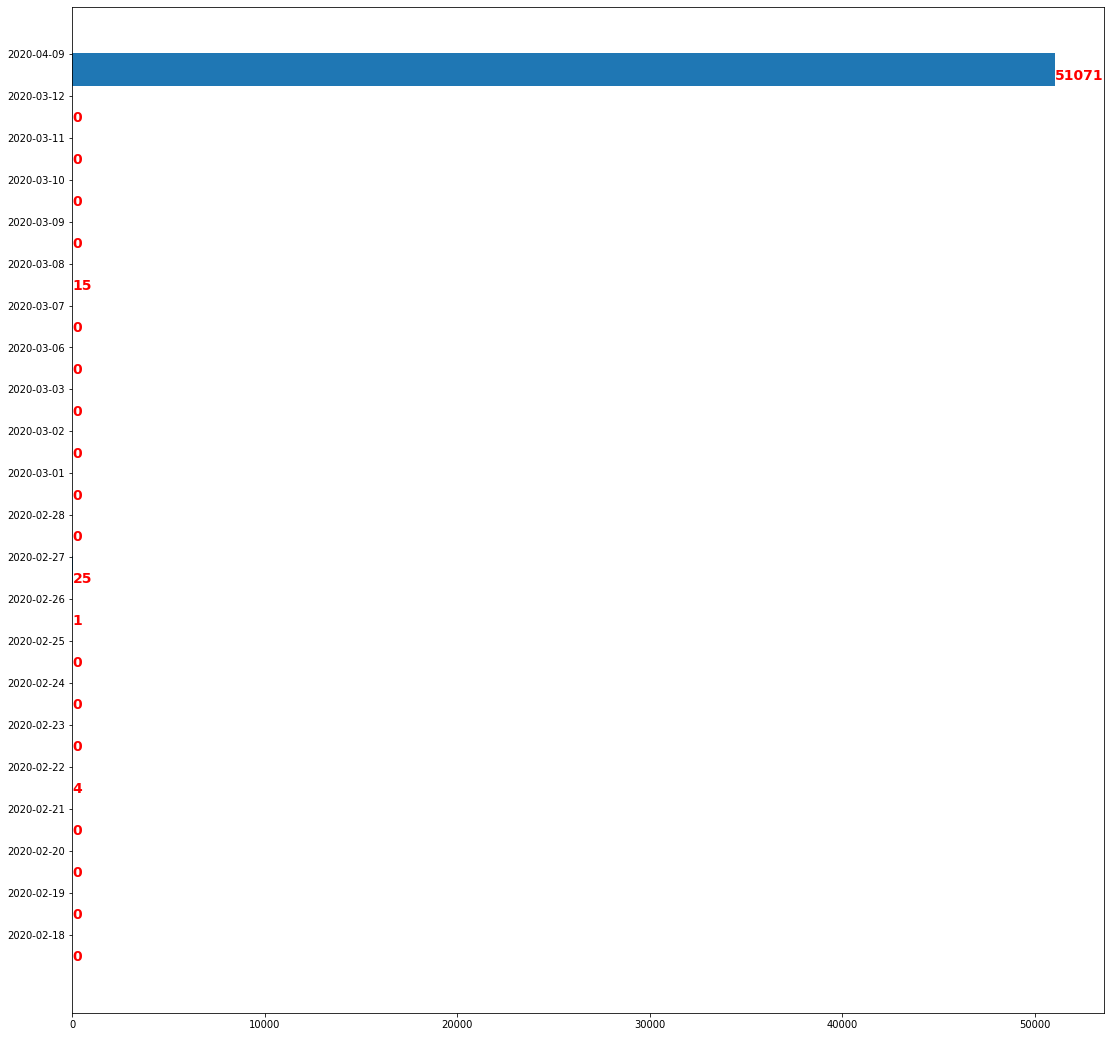

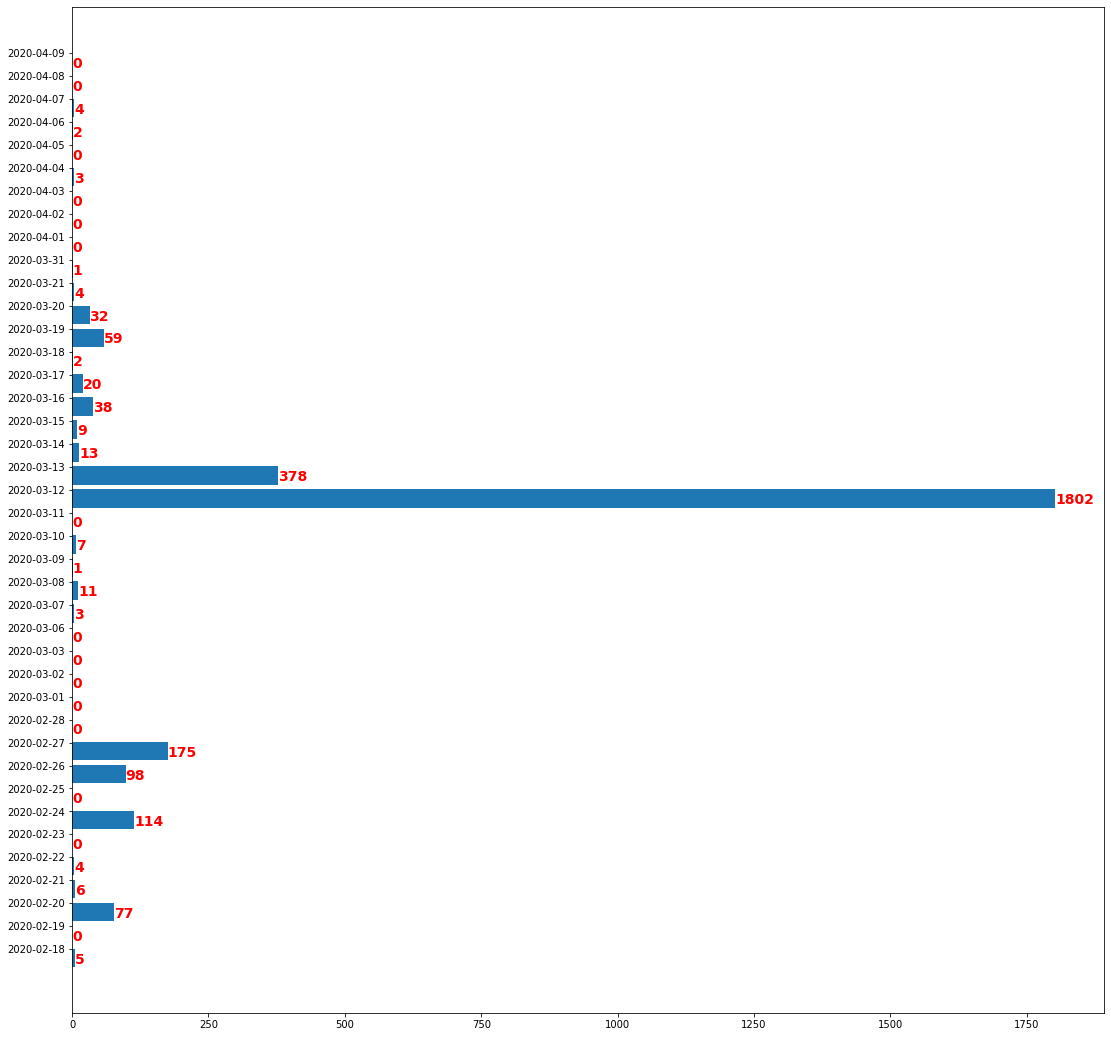

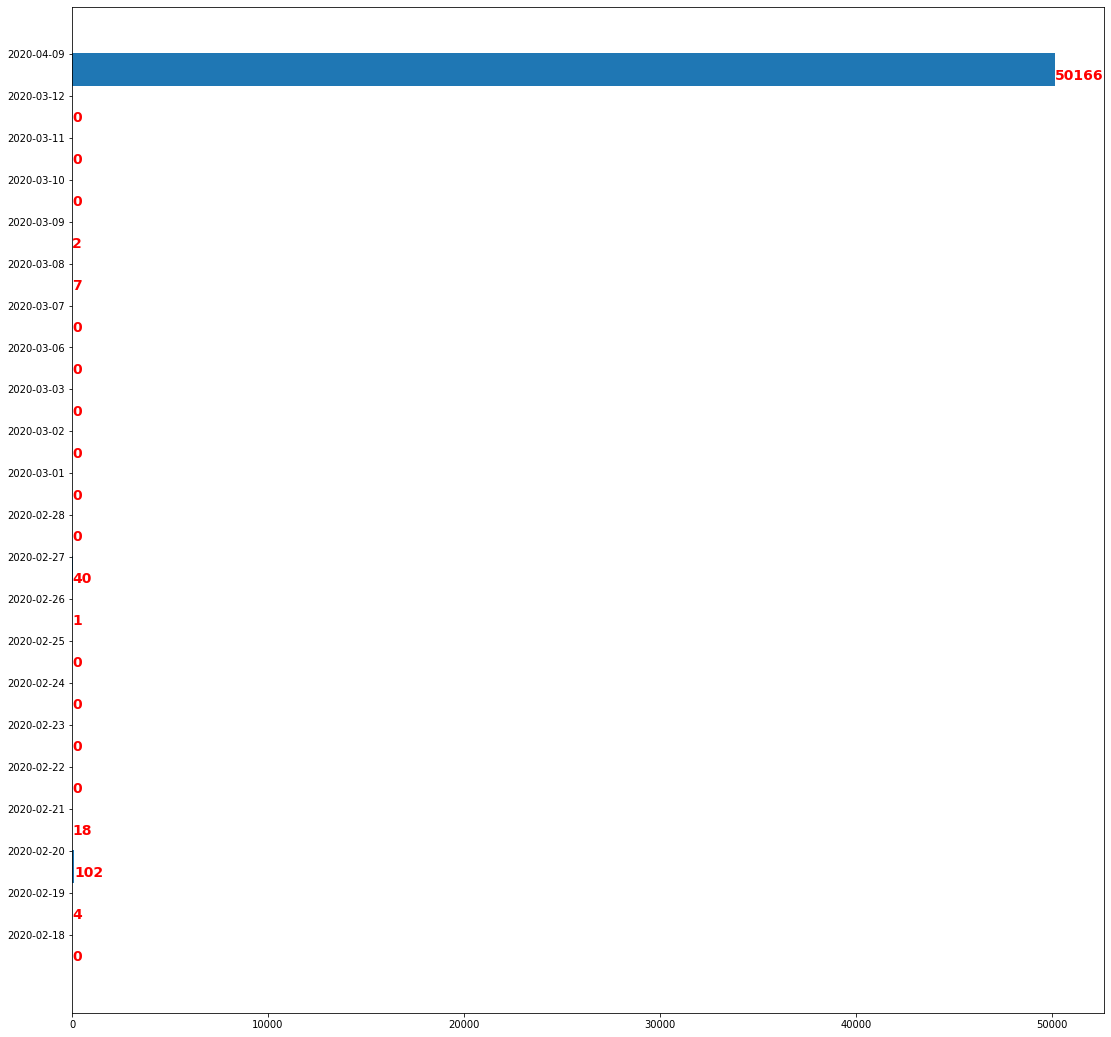

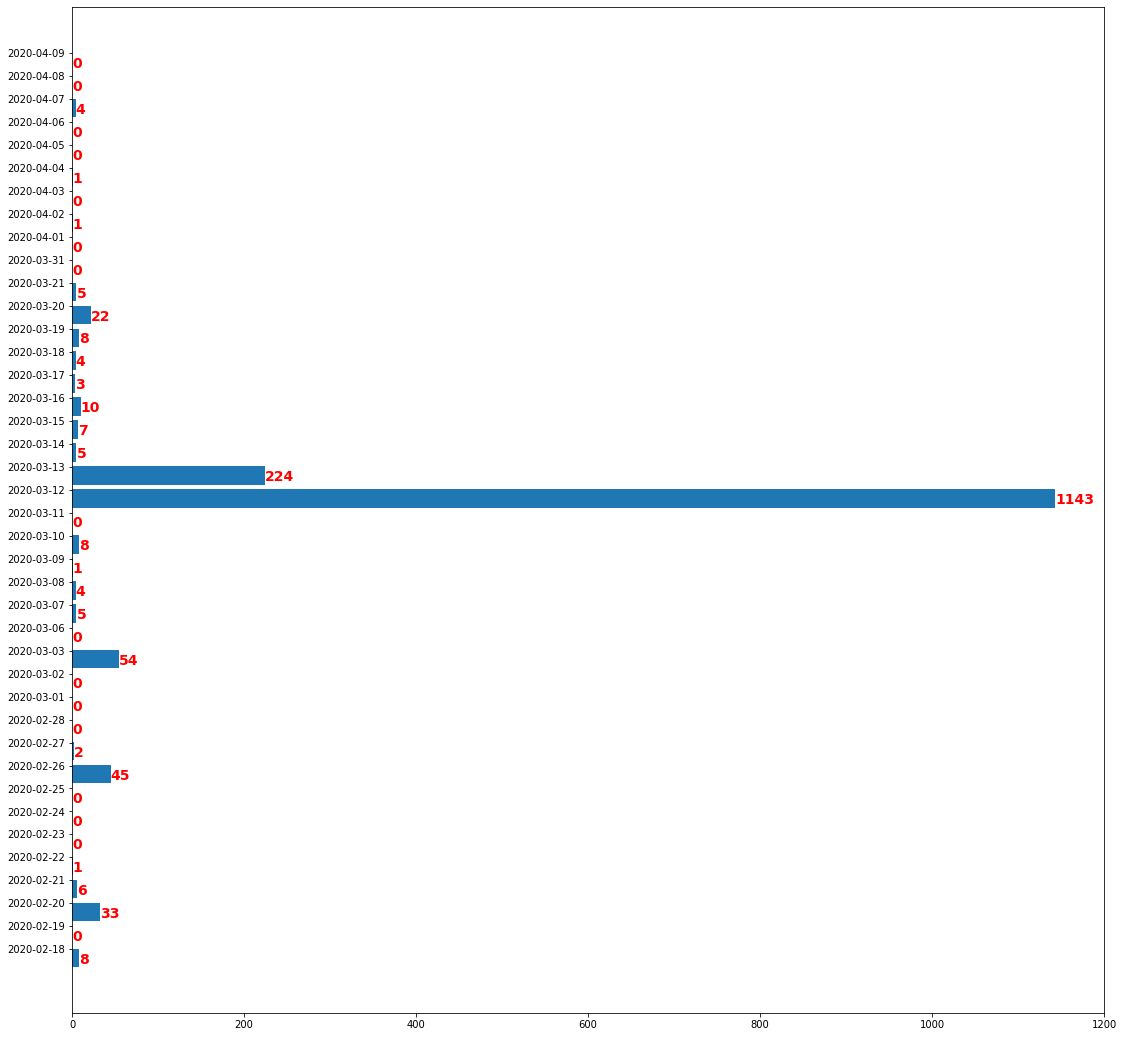

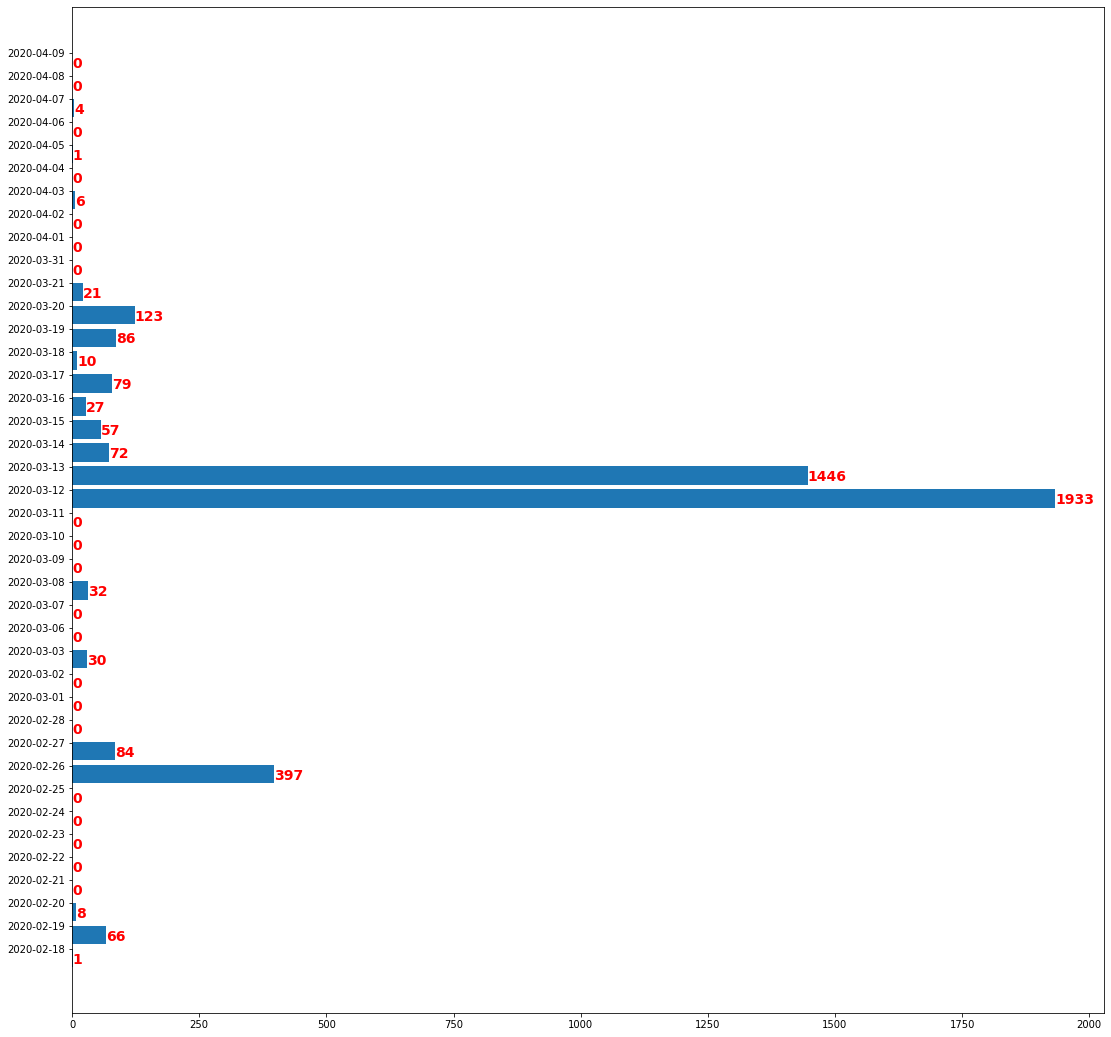

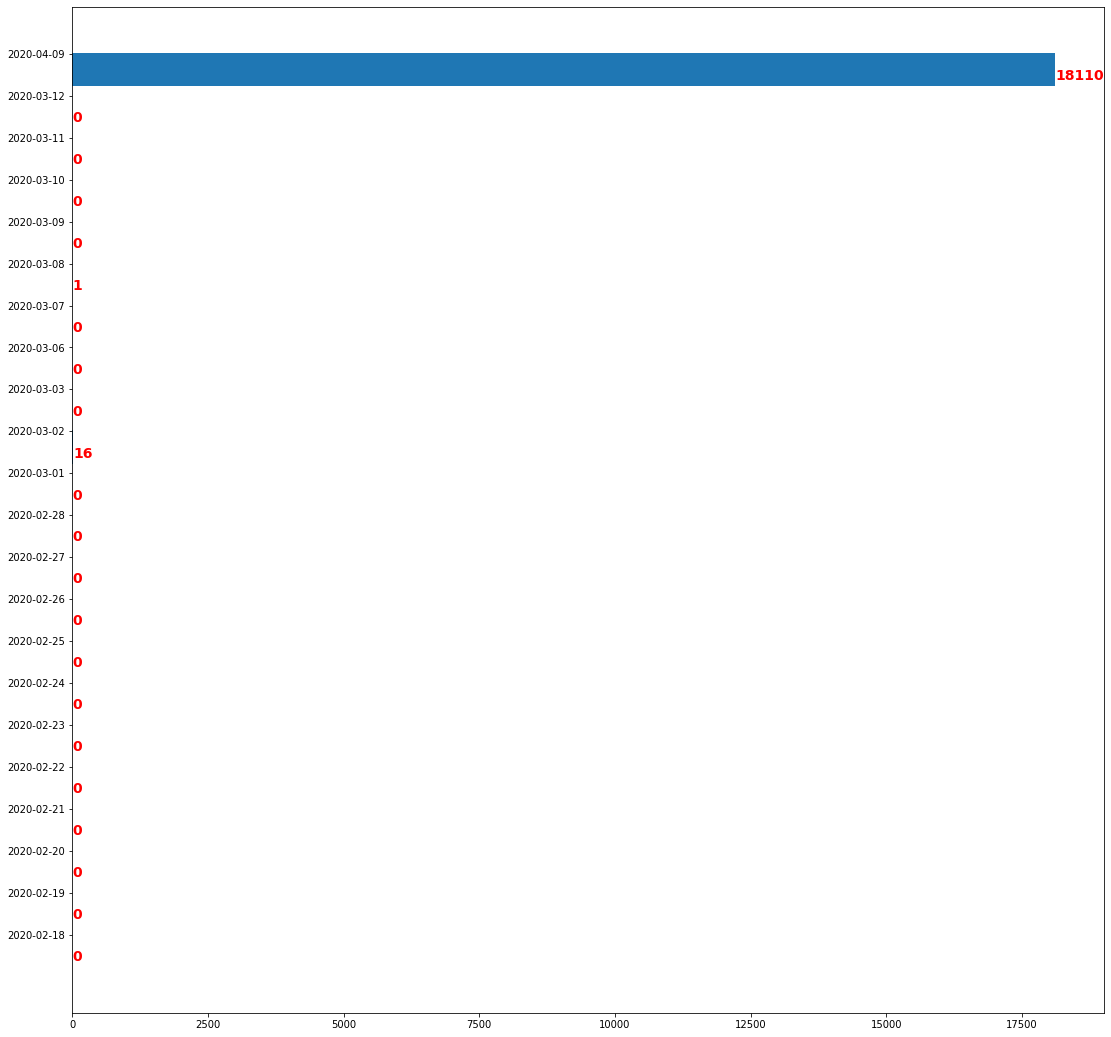

In [39]:
path = "./output_data/"    

count = 0
stop = 99
tr = None
for directory in fetch_directories(path):
#     print(count)
    count += 1
    triangle = Triangle(fetch_files(directory), directory, directory[len(path):])
    arbitrages_counts, dates = triangle.get_arbitrages_counts()
    
    # ---------------------------------------- plot
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(arbitrages_counts))  # the x locations for the groups
    ax.barh(np.arange(len(arbitrages_counts)), arbitrages_counts, align='center')
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(dates)
    fig.set_size_inches(18.5, 18.5)
    for i, v in enumerate(arbitrages_counts):
        ax.text(v, i - 0.25, str(v), color='red', fontweight='bold', fontsize=14)
#     plt.savefig(os.path.join('arbitrages_count/' + triangle.name + '.png'), dpi=300, format='png')
    plt.show()
    # !---------------------------------------- plot
    
    if count == stop:
        break

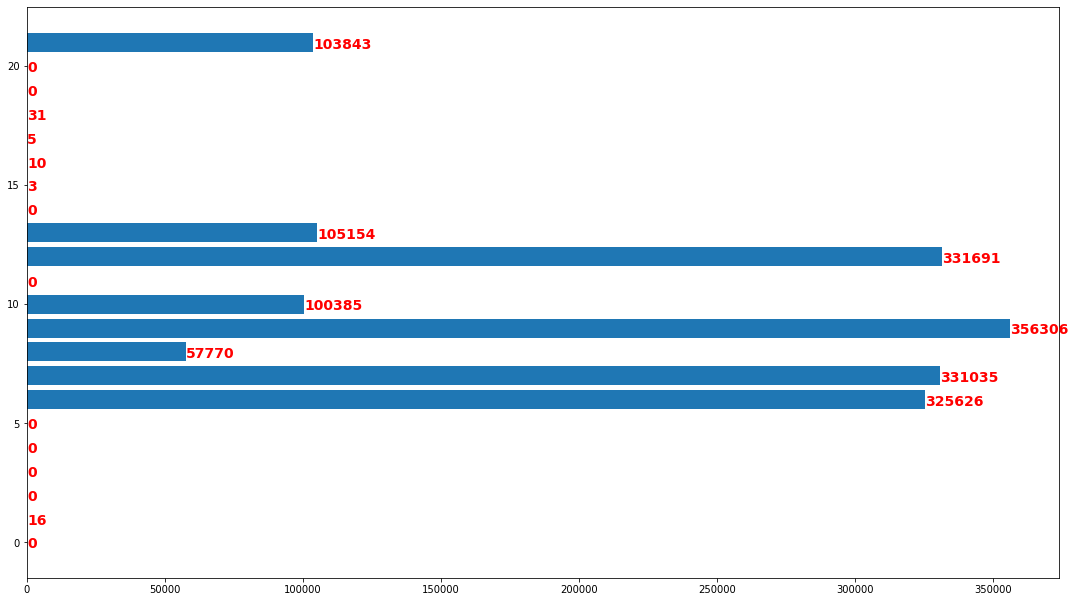

In [9]:
arbitrages_counts = tr.get_arbitrages_counts()

fig, ax = plt.subplots()    
ax.barh(np.arange(len(arbitrages_counts)), arbitrages_counts, align='center')
fig.set_size_inches(18.5, 10.5)
for i, v in enumerate(arbitrages_counts):
    ax.text(v, i - 0.25, str(v), color='red', fontweight='bold', fontsize=14)
plt.show()

In [111]:
df = {}
with open("./output_data/USDTBTCBCH/USDTBTCBCH-2020-02-26.json") as f:
    df = json.loads(f.read())
df

{'arbitrage_stats': [{'score': 1.00301,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 1.76532e-07,
   'demand_gain': 0,
   'calculation_type_linear': 0,
   'pairs': [{'id': 330857177,
     'timestamp': 1582675273.883601,
     'currency': 'BCHUSDT'},
    {'id': 91640475, 'timestamp': 1582675251.477481, 'currency': 'BCHBTC'},
    {'id': 2251827135, 'timestamp': 2251821479.0, 'currency': 'BTCUSDT'}]},
  {'score': 1.00345,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 0,
   'demand_gain': 2.55761e-05,
   'calculation_type_linear': 0,
   'pairs': [{'id': 330868578,
     'timestamp': 1582675348.902344,
     'currency': 'BCHUSDT'},
    {'id': 91642704, 'timestamp': 1582675348.499431, 'currency': 'BCHBTC'},
    {'id': 2251827135, 'timestamp': 2251821479.0, 'currency': 'BTCUSDT'}]},
  {'score': 1.00345,
   'supply_gain_index': [0, 0, 0],
   'demand_gain_index': [0, 0, 0],
   'supply_gain': 0,
   'demand_gain': 2

In [124]:
from statistics import median
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

0.05085973118

In [125]:
median([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * df['arbitrages_count'] * rate['BCH']

2938.1666702686

In [126]:
sum([x['demand_gain'] for x in df['arbitrage_stats'] if x['demand_gain'] > 0]) * rate['BCH']

606.8191572544976

In [46]:
df = {}
with open("./test/BTCBCHBNB/BTCBCHBNB-2020-02-26.json") as f:
    df = json.loads(f.read())
df

[{'score': 1.00016,
  'supply_gain_index': [0, 0, 0],
  'demand_gain_index': [0, 0, 0],
  'supply_gain': 1.14296e-08,
  'demand_gain': 0,
  'calculation_type_linear': 0,
  'pairs': [{'id': 92918138,
    'demand': [[0.035287, 2.11],
     [0.035286, 1.906],
     [0.035279, 2.0],
     [0.035277, 0.963],
     [0.035276, 0.242]],
    'supply': [[0.035314, 0.196],
     [0.035315, 2.0],
     [0.035317, 6.667],
     [0.035336, 0.243],
     [0.035344, 0.243]],
    'timestamp': 1582728843.69997,
    'currency': 'BCHBTC'},
   {'id': 22997311,
    'demand': [[16.892, 0.026],
     [16.872, 0.1],
     [16.866, 0.047],
     [16.853, 0.018],
     [16.851, 0.079]],
    'supply': [[16.926, 0.963],
     [16.927, 0.028],
     [16.962, 0.035],
     [16.974, 3.281],
     [16.975, 20.539]],
    'timestamp': 1582728843.752795,
    'currency': 'BCHBNB'},
   {'id': 584585061,
    'demand': [[0.002091, 1.0],
     [0.00209, 6.16],
     [0.00209, 99.51],
     [0.00209, 89.3],
     [0.00209, 108.07]],
    'supply':

In [3]:
scores = [x["score"] for x in df]
print("Number of arbitrages:", len(scores))
print("Average score:", sum(scores)/len(scores))
print("Maximum score:", max(scores))
print("Minimum score:", min(scores))

Number of arbitrages: 1316
Average score: 1.00043710486322
Maximum score: 1.00307
Minimum score: 1


In [7]:
def get_narrowest(p1: [float], p2: [float], p3: [float]) -> float:
    a = []
    a.append(min(np.prod(p2), p1[1]))
    a.append(min(np.prod(p3), p2[1]))
    a.append(min(np.prod(p1), p3[1]))
    a[1] = a[1] * p1[0]
    a[2] = a[2] * p2[0] * p1[0]
    return min(a)


# def get_max_gain(df):
#     pairs = df['pairs']
#     max_gain = 0
#     for p1 in pairs[0]['supply']:
#         for p2 in pairs[1]['demand']:
#             for p3 in pairs[2]['demand']:
#                 score = p1[0]/p2[0]/p3[0]
#                 if score > 1:
#                     gain = get_narrowest(p1, p2, p3) * (score-1)
#                     if max_gain < gain:
#                         max_gain = gain
#     return max_gain

# gains = []
# for d in df:
#     gains.append(get_max_gain(d))

# currency = df[0]['pairs'][0]['currency'][0:3]
# print("Total daily market inefficiency:", sum(gains), currency)
# print("Max theoretical daily gain:", max(gains), currency)

Total daily market inefficiency: 0.04784531213980099 BCH
Max theoretical daily gain: 0.00048003769667434744 BCH


In [ ]:
# ts = []
# print("initializing")

# for i in range(stop):
#     ts.append(threading.Thread(target=basic_stats, args=(triangles[i], str(i),)))
# print("starting")
# for t in ts:
#     t.start()
# for t in ts:
#     t.join()
# print("done")